# Projet Data Mining : Text classification

                    Rebecca Leygonie, N° étudiant : 19000002
                    Nemanja Kostadinovic, N° étudiant : 19000001


Ce projet consiste à analyser les données issues 20newsgroups, extraire les caractéristiques textuelles selon
plusieurs méthodes et appliquer des modèles de classification afin de retrouver les catégories des articles.

Sommaire général du projet : 

            1  -  Import et analyse exploratoire des données
            2  -  Extraction de caractéristiques du texte avec TF-IDF
            3  -  Modèles de classification (utilisant tf-idf)
            4  -  Autres transformations :
                    -  HashingVectorizer
                    -  Word2Vec
                    -  Doc2Vec :
                           . comparaison de modèles de classification
                    -  LDA
       
            5  -  Analyses sur la base de données Voiture
            6  -  Conclusion
            
      

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from sklearn import *
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import  confusion_matrix, accuracy_score, mean_squared_error, r2_score, classification_report, silhouette_score, homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, f1_score
import sklearn.decomposition
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF



from sklearn.pipeline import make_pipeline

from sklearn.tree import DecisionTreeClassifier


from sklearn.decomposition import LatentDirichletAllocation

from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression

from sklearn.linear_model import Perceptron

from sklearn.preprocessing import Normalizer


import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re 

from collections import defaultdict  
import spacy

import gensim
from tqdm import tqdm
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess
from sklearn import utils


from joblib import cpu_count
from collections import Counter
import logging 
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from sklearn.manifold import TSNE

unable to import 'smart_open.gcs', disabling that module


## 1 -  Import et analyse exploratoire des données

In [2]:
twenty_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
twenty_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42)

### 20 newsgroups training dataset

In [3]:
print('Training data size:', len(twenty_train.data))

Training data size: 11314


In [4]:
# toutes les catéogries
len(twenty_train.target)

11314

In [5]:
print("\n".join(twenty_train.data[0].split("\n")[:3]))
print(twenty_train.target_names[twenty_train.target[0]])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
rec.autos


In [6]:
# frequence de chaque catégorie
categories = twenty_train.target_names
target, freq = np.unique(twenty_train.target, return_counts=True)
print(list(zip(categories, freq)))

[('alt.atheism', 480), ('comp.graphics', 584), ('comp.os.ms-windows.misc', 591), ('comp.sys.ibm.pc.hardware', 590), ('comp.sys.mac.hardware', 578), ('comp.windows.x', 593), ('misc.forsale', 585), ('rec.autos', 594), ('rec.motorcycles', 598), ('rec.sport.baseball', 597), ('rec.sport.hockey', 600), ('sci.crypt', 595), ('sci.electronics', 591), ('sci.med', 594), ('sci.space', 593), ('soc.religion.christian', 599), ('talk.politics.guns', 546), ('talk.politics.mideast', 564), ('talk.politics.misc', 465), ('talk.religion.misc', 377)]


On converti les données en DataFrame pour pouvoir les visualiser

In [7]:
train_df = pd.DataFrame({'data': twenty_train.data, 'target': twenty_train.target})
train_df.head()

data  target
0  From: lerxst@wam.umd.edu (where's my thing)\nS...       7
1  From: guykuo@carson.u.washington.edu (Guy Kuo)...       4
2  From: twillis@ec.ecn.purdue.edu (Thomas E Will...       4
3  From: jgreen@amber (Joe Green)\nSubject: Re: W...       1
4  From: jcm@head-cfa.harvard.edu (Jonathan McDow...      14

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


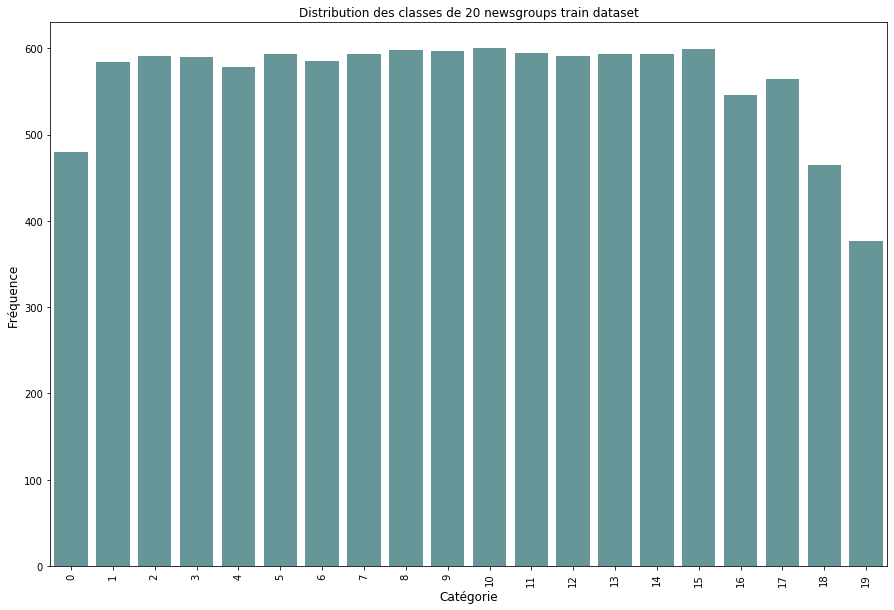

In [9]:
plt.figure(figsize=(15,10))
plt.ylabel('Fréquence', fontsize=12)
plt.xlabel('Catégorie', fontsize=12)
sns.barplot(target, freq, color='cadetblue')
plt.xticks(rotation='vertical')
plt.title('Distribution des classes de 20 newsgroups train dataset')
print(twenty_train.target_names)

On observe que les catégories qui contiennent le moins de documents sont : "talk.religion.misc" et "alt.atheism"

### 20 newsgroups test dataset

In [10]:
twenty_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42)
print('Testing data size:', len(twenty_test.data))

Testing data size: 7532


On compte le nombre de documents pour chaque catégorie.

In [11]:
# fréquence de chaque catégorie
categories_test = twenty_test.target_names
target_test, freq_test = np.unique(twenty_test.target, return_counts=True)
print(list(zip(categories_test, freq_test)))

[('alt.atheism', 319), ('comp.graphics', 389), ('comp.os.ms-windows.misc', 394), ('comp.sys.ibm.pc.hardware', 392), ('comp.sys.mac.hardware', 385), ('comp.windows.x', 395), ('misc.forsale', 390), ('rec.autos', 396), ('rec.motorcycles', 398), ('rec.sport.baseball', 397), ('rec.sport.hockey', 399), ('sci.crypt', 396), ('sci.electronics', 393), ('sci.med', 396), ('sci.space', 394), ('soc.religion.christian', 398), ('talk.politics.guns', 364), ('talk.politics.mideast', 376), ('talk.politics.misc', 310), ('talk.religion.misc', 251)]


In [12]:
test_df = pd.DataFrame({'data': twenty_test.data, 'target': twenty_test.target})
test_df.head()

data  target
0  From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...       7
1  From: Rick Miller <rick@ee.uwm.edu>\nSubject: ...       5
2  From: mathew <mathew@mantis.co.uk>\nSubject: R...       0
3  From: bakken@cs.arizona.edu (Dave Bakken)\nSub...      17
4  From: livesey@solntze.wpd.sgi.com (Jon Livesey...      19

Text(0.5, 1.0, 'Distribution des classes de 20 newsgroups test dataset')

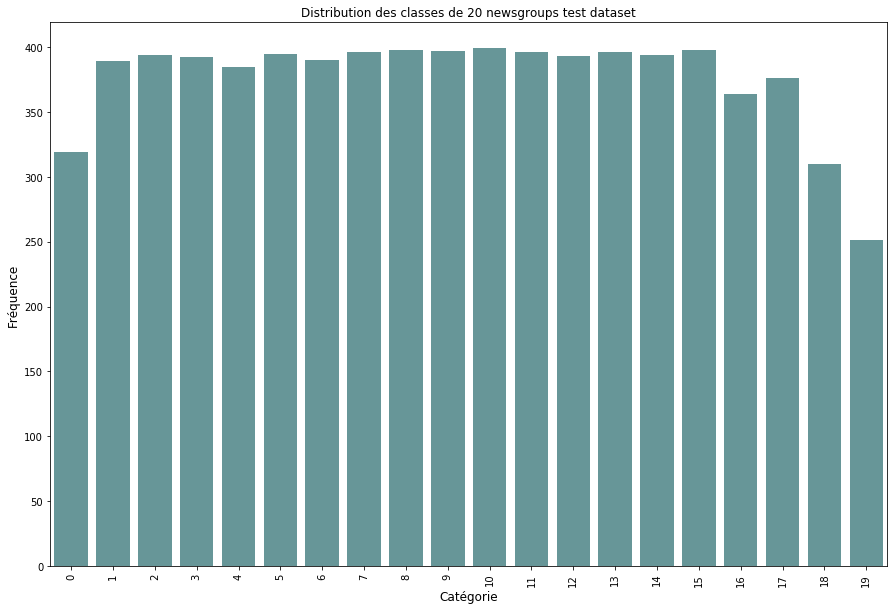

In [13]:
plt.figure(figsize=(15,10))
plt.ylabel('Fréquence', fontsize=12)
plt.xlabel('Catégorie', fontsize=12)
sns.barplot(target_test, freq_test, color='cadetblue')
plt.xticks(rotation='vertical')
plt.title('Distribution des classes de 20 newsgroups test dataset')

On observe que la répartition des catégories des documents sont bien répartis et représentatifs dans le train et le test. 

### 20 newsgroups all dataset

In [14]:
twenty_all = fetch_20newsgroups(subset='all', shuffle=True, random_state=42)
print('Training data size:', len(twenty_all.data))

Training data size: 18846


## 2 - Extraction de caractéristiques du texte avec TF-IDF

$Tf$ signifie fréquence d'un terme tandis que $tf-idf$ signifie fréquence d'un terme multiplié par la fréquence inverse du document. Il s'agit d'un système de pondération des termes courant dans la recherche d'informations, qui a également fait ses preuves dans la classification des documents.

L'utilisation de $tf-idf$ au lieu des fréquences brutes d'occurrence d'un mot dans un document donné a pour but de réduire l'impact des mots qui se produisent très fréquemment dans un corpus donné et qui sont donc empiriquement moins informatifs que les caractéristiques qui se produisent dans une petite fraction du corpus de formation.

La formule utilisée pour calculer le $tf-idf$ pour un terme $t$ d'un document $d$ dans un ensemble de documents est : $$ tf-idf(t, d) = tf(t, d) * idf(t)$$et l'$idf$ est calculé comme suit : $$ idf(t) = log [ n / df(t) ] + 1 $$ (si $smooth_idf=False$), où $n$ est le nombre total de documents dans l'ensemble de documents et $df(t)$ est la fréquence de document de $t$ ; la fréquence des documents est le nombre de documents dans l'ensemble de documents qui contiennent le terme $t$.
L'ajout de "1" à l'$idf$ dans l'équation ci-dessus a pour effet que les termes dont l'$idf$ est nul, c'est-à-dire les termes qui apparaissent dans tous les documents d'un ensemble de formation ne seront pas entièrement ignorés. 

Si $smooth_idf=True$ (la valeur par défaut), la constante "1" est ajoutée au numérateur et au dénominateur de l'$idf$ comme si un document supplémentaire était vu contenant chaque terme de la collection exactement une fois, ce qui empêche les divisions zéro : $$idf(d, t) = log [ (1 + n) / (1 + df(d, t)) ] + 1$$.

### Count Vectorizer

In [15]:
count_vect = CountVectorizer(stop_words='english')
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_counts.shape

(11314, 129796)

Le "stop_words='english" signifie que les mots comme "the", "a", etc, qui n'apportent pas d'informations importantes dans la langue anglaise, ne seront pas pris en compte.

In [16]:
count_vect.vocabulary_.get(u'2000') 

8268

In [17]:
X_train_counts_df = pd.DataFrame(X_train_counts.todense())
X_train_counts_df.columns = sorted(count_vect.get_feature_names())
X_train_counts_df.sample(5)

00  000  0000  00000  000000  00000000  0000000004  0000000005  \
5536   0    0     0      0       0         0           0           0   
6086   0    0     0      0       0         0           0           0   
5225   0    0     0      0       0         0           0           0   
637    0    0     0      0       0         0           0           0   
6552   0    0     0      0       0         0           0           0   

      00000000b  00000001  ...  çon  ère  ée  égligent  élangea  érale  ête  \
5536          0         0  ...    0    0   0         0        0      0    0   
6086          0         0  ...    0    0   0         0        0      0    0   
5225          0         0  ...    0    0   0         0        0      0    0   
637           0         0  ...    0    0   0         0        0      0    0   
6552          0         0  ...    0    0   0         0        0      0    0   

      íålittin  ñaustin  ýé  
5536         0        0   0  
6086         0        0   0  
5225         0        0   0  
637          0        0   0  
6552         0        0   0  

[5 rows x 129796 columns]

In [18]:
X_test_counts = count_vect.transform(twenty_test.data)
X_test_counts.shape

(7532, 129796)

In [19]:
X_test_counts_df = pd.DataFrame(X_test_counts.todense())
X_test_counts_df.columns = sorted(count_vect.get_feature_names())
X_test_counts_df.sample(5)

00  000  0000  00000  000000  00000000  0000000004  0000000005  \
5061   0    0     0      0       0         0           0           0   
5622   0    0     0      0       0         0           0           0   
5007   0    0     0      0       0         0           0           0   
3391   0    0     0      0       0         0           0           0   
2215   0    0     0      0       0         0           0           0   

      00000000b  00000001  ...  çon  ère  ée  égligent  élangea  érale  ête  \
5061          0         0  ...    0    0   0         0        0      0    0   
5622          0         0  ...    0    0   0         0        0      0    0   
5007          0         0  ...    0    0   0         0        0      0    0   
3391          0         0  ...    0    0   0         0        0      0    0   
2215          0         0  ...    0    0   0         0        0      0    0   

      íålittin  ñaustin  ýé  
5061         0        0   0  
5622         0        0   0  
5007         0        0   0  
3391         0        0   0  
2215         0        0   0  

[5 rows x 129796 columns]

In [20]:
X_all_counts = count_vect.transform(twenty_all.data)
X_all_counts.shape

(18846, 129796)

### TF-IDF Transformer 
(Count Vectorizer -> TF-IDF)

In [21]:
tfidf_transformer = TfidfTransformer()

train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
train_tfidf.shape

(11314, 129796)

In [22]:
train_tfidf_df = pd.DataFrame(train_tfidf.todense())
train_tfidf_df.columns = sorted(count_vect.get_feature_names())
train_tfidf_df.sample(5)

00  000  0000  00000  000000  00000000  0000000004  0000000005  \
9748   0.0  0.0   0.0    0.0     0.0       0.0         0.0         0.0   
10595  0.0  0.0   0.0    0.0     0.0       0.0         0.0         0.0   
2366   0.0  0.0   0.0    0.0     0.0       0.0         0.0         0.0   
1201   0.0  0.0   0.0    0.0     0.0       0.0         0.0         0.0   
6928   0.0  0.0   0.0    0.0     0.0       0.0         0.0         0.0   

       00000000b  00000001  ...  çon  ère   ée  égligent  élangea  érale  ête  \
9748         0.0       0.0  ...  0.0  0.0  0.0       0.0      0.0    0.0  0.0   
10595        0.0       0.0  ...  0.0  0.0  0.0       0.0      0.0    0.0  0.0   
2366         0.0       0.0  ...  0.0  0.0  0.0       0.0      0.0    0.0  0.0   
1201         0.0       0.0  ...  0.0  0.0  0.0       0.0      0.0    0.0  0.0   
6928         0.0       0.0  ...  0.0  0.0  0.0       0.0      0.0    0.0  0.0   

       íålittin  ñaustin   ýé  
9748        0.0      0.0  0.0  
10595       0.0      0.0  0.0  
2366        0.0      0.0  0.0  
1201        0.0      0.0  0.0  
6928        0.0      0.0  0.0  

[5 rows x 129796 columns]

In [23]:
test_tfidf = tfidf_transformer.transform(X_test_counts)
test_tfidf.shape

(7532, 129796)

In [24]:
all_tfidf = tfidf_transformer.transform(X_all_counts)
all_tfidf.shape

(18846, 129796)

## 3 - Modèle de classification (utilisant tf-idf)

Voici les différents modèles utilisés dans cette partie, l'extraction des caractéristiques textuelle a été effectuée à l'aide de tf-idf, suivi de la matrice de confusion puis décomposition SVD et NMF.

                                 -- Apprentissage supervisé -- 
 
                                    A. Multinominal Naive Bayes 
                                    B. Stochastic Gradient Descent Classifier (SGD)
                                    C. k Nearest Neighbors (kNN)
                                    D. Régression logistique
                                    E. Decision Tree
                                    F. Linear SVC
                                    G. Régression Linéaire
                                    H. Perceptron
                                    I. Comparatif
    
                                 -- Apprentissage non supervisé -- 
                                 
                                    J. KMeans
                                        - KMeans sur les données transformées avec TF-IDF
                                        - KMeans sur les données transformées avec SVD
                                        - KMeans sur les données transformées avec NMF
                                     
    
       

### A. Multinominal Naive Bayes

MultinomialNB implémente l'algorithme naïf Bayes pour les données distribuées multinomiales et est l'une des deux variantes Bayes naïves classiques utilisées dans la classification de texte où les données sont généralement représentées par le nombre de vecteurs de mots ou avec les vecteurs tf-idf.

La distribution est paramétrée par des vecteurs θy=(θy1,…,θyn) pour chaque classe y, où n est le nombre de caractéristiques (dans la classification de texte, la taille du vocabulaire) et θyi est la probabilité de P(xi∣y) de la caractéristique i apparaissant dans un échantillon appartenant à la classe y.

Les paramètres θy sont estimés par une version "smoothed" du maximum de vraisemblance, c'est-à-dire le comptage de fréquence relative: 
                                            
                                            θyi=Nyi+α / Ny+αn.

où Nyi est le nombre de fois où la caractéristique i apparaît dans un échantillon de classe y dans l'ensemble d'apprentissage T.

In [25]:
clf = MultinomialNB(alpha=0.001).fit(train_tfidf, twenty_train.target)
predicted = clf.predict(test_tfidf)
MNB = accuracy_score(twenty_test.target,predicted)
print(MNB)

0.8230217737652682


Il est interréssant de regarder la matrice de confusion pour chaque modèle pour voir les catégories qu'il n'arrive pas à vraiment distinguer.

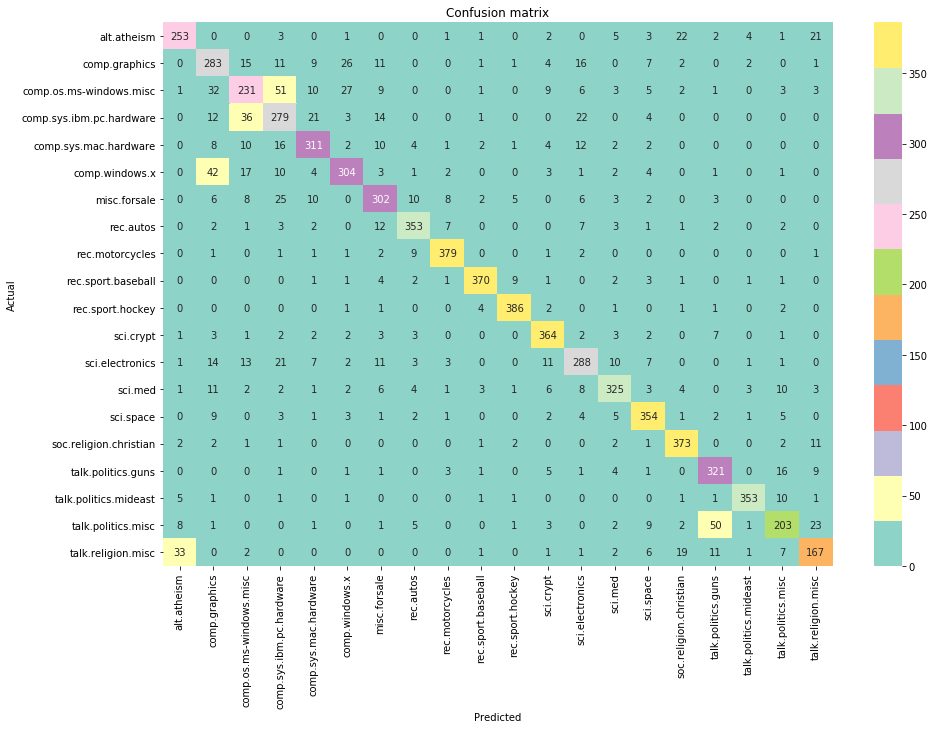

In [26]:
conf_mat = confusion_matrix(twenty_test.target, predicted)
labels=twenty_all.target_names
# Plot confusion_matrix
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(conf_mat, annot=True, cmap = "Set3", fmt ="d",
xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

On observe que les catégories "alt.atheism" et talk.religion.misc sont parfois confondues. Ce sont deux catégories à propos de la religion donc on comprends pourquoi elles sont parfois mal différenciées. 
Pareil pour "comp.os.ms.windows.misc" et "comp.sys.ibm.pc.hardware" qui sont deux catégories d'informatiques, "talk.politics.guns" et "talk.politic.misc" qui sont des catégories de politiques. Etc.


Afin de visualiser les données graphiquement, il faut les mettres en 2D. Pour cela, il existe plusieurs méthodes comme LDA ou ACP que nous avons vu en cours. Cependant, ces méthodes ne marchent pas bien avec des données textuelles (même après transformations en vecteur).
Pour ce type de cas, les decomposition qui sont plus adaptées sont les décomposition SVD et NMF. Nous allons donc visualiser les résultats de chaque modèle avec ces décomposition.

### Decomposition SVD

Ce transformateur effectue une réduction de la dimensionnalité linéaire au moyen d'une décomposition de valeur singulière tronquée (SVD). Contrairement à l'ACP, cet estimateur ne centre pas les données avant de calculer la décomposition en valeur singulière. Cela signifie qu'il peut travailler efficacement avec les matrices scipy.sparse.

En particulier, la SVD tronquée fonctionne sur les matrices de comptage de termes/tf-idf telles que renvoyées par les vectoriseurs dans sklearn.feature_extraction.text.

Cet estimateur prend en charge deux algorithmes : un solveur SVD rapide et aléatoire, et un algorithme "naïf" qui utilise ARPACK comme eigensolver sur $(X * X.T)$ ou $(X.T * X)$, selon ce qui est le plus efficace.

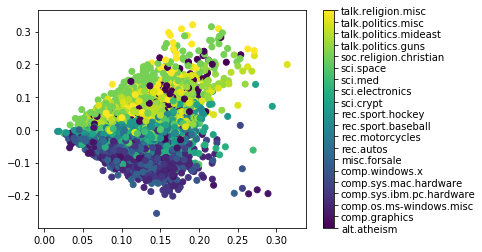

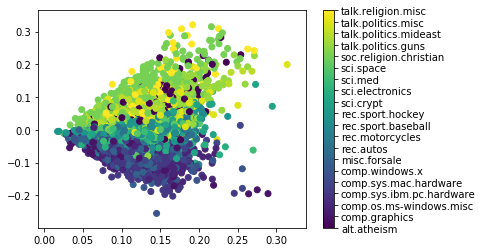

In [27]:
svd = TruncatedSVD(n_components=2)
SVD=svd.fit_transform(test_tfidf)
plt.figure()
plt.scatter(SVD[:,0],SVD[:,1],c=twenty_test.target)
formatter = plt.FuncFormatter(lambda i, args : twenty_test.target_names[int(i)])
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)
plt.figure()
plt.scatter(SVD[:,0],SVD[:,1],c=predicted)
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)

On observe que le modèle n'a pas réussi à bien séparer les classes (plus de points violets dans l'affichage des target que dans celui du predicted).
Le fait est que le jeu de données est trop important pour voir clairement les séparations qu'il a faite.
De plus, on remarque que les catégories qui sont le moins bien séparées sont celles que l'on a noté "confondables" d'après la matrice de confusion. 

### Décomposition NMF

Non-Negative Matrix Factorization (NMF)

Trouver deux matrices non négatives (W, H) dont le produit se rapproche de la matrice non négative X. Cette factorisation peut être utilisée par exemple pour la réduction de la dimensionnalité, la séparation des sources ou l'extraction de sujets.

La fonction objective est :


$0.5 * ||X - WH||_Fro^2 + alpha * l1_ratio * ||vec(W)||_1 + alpha * l1_ratio * ||vec(H)||_1 + 0.5 * alpha * (1 - l1_ratio) * ||W||_Fro^2 + 0.5 * alpha * (1 - l1_ratio) * ||H||_Fro^2$

ou 
$$||A||_Fro^2 = \sum_{i,j} A_{ij}^2$$ 
$$||vec(A)||_1 = \sum_{i,j} abs(A_{ij}) $$


La fonction objectif est minimisée avec une minimisation alternée de W et H.

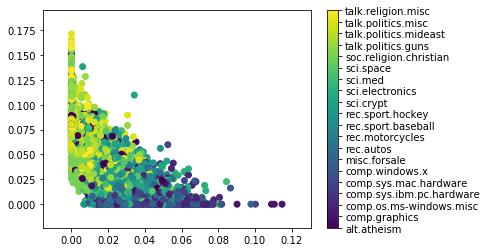

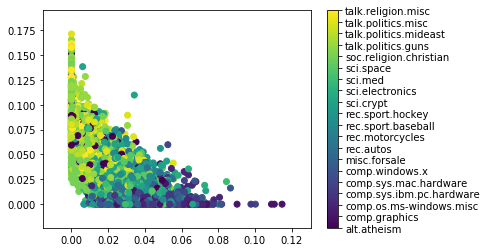

In [29]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=2)
NMF=nmf.fit_transform(test_tfidf)
plt.figure()
plt.scatter(NMF[:,0],NMF[:,1],c=twenty_test.target)
formatter = plt.FuncFormatter(lambda i, args : twenty_test.target_names[int(i)])
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)
plt.figure()
plt.scatter(NMF[:,0],NMF[:,1],c=predicted)
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)

Comme dit précédement, il est difficile de visualiser les résultat du modèle avec autant de données. 
Nous avons donc décidé de re-appliquer le modèle sur une partie minime du jeu de données. Pour cela nous ne gardons que 4 catégories. 
Nous allons donc essayer d'abord de regarder le comportement du classifieur avec des catégories qui a priori sont proches (2 par 2) -> "talk.religion.misc", "alt.atheism", "comp.windows.x" et "comp.graphics"

Puis avec des catégories qui n'ont pas de confusions entre elles -> "rec.motorcycles","sci.space", "soc.religion.christian","misc.forsale"

Pour cette partie, nous utilisons seulement la décomposition SVD pour visualiser le résultat

accuracy :  0.8426883308714919


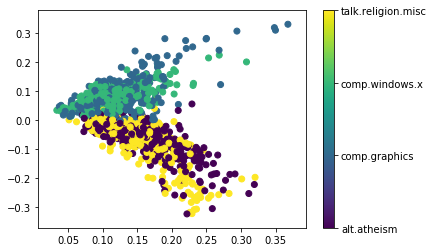

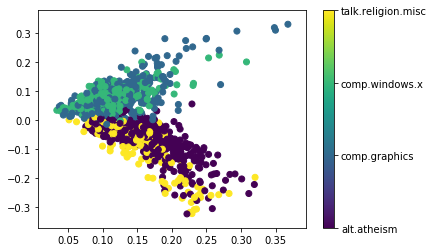

In [30]:
categories = ['talk.religion.misc','alt.atheism','comp.windows.x','comp.graphics']

train_1 = fetch_20newsgroups(subset='train',categories=categories, shuffle=True, random_state=42)
count_vect_1 = CountVectorizer()
train_counts_1 = count_vect.fit_transform(train_1.data)
tfidf_transformer_1 = TfidfTransformer()
train_tfidf_1 = tfidf_transformer.fit_transform(train_counts_1)
clf = MultinomialNB().fit(train_tfidf_1, train_1.target)
test_1 = fetch_20newsgroups(subset='test',categories=categories)
test_counts_1 = count_vect.transform(test_1.data)
test_tfidf_1 = tfidf_transformer.transform(test_counts_1)
predicted_1 = clf.predict(test_tfidf_1)

print("accuracy : ",accuracy_score(test_1.target,predicted_1))

svd = TruncatedSVD(n_components=2)
SVD=svd.fit_transform(test_tfidf_1)
plt.figure()
plt.scatter(SVD[:,0],SVD[:,1],c=test_1.target)
formatter = plt.FuncFormatter(lambda i, args : test_1.target_names[int(i)])
plt.colorbar(ticks=[0,1,2,3],format=formatter)
plt.figure()
plt.scatter(SVD[:,0],SVD[:,1],c=predicted_1)
plt.colorbar(ticks=[0,1,2,3],format=formatter)

On remarque que lorsque l'on prend seulement les catégories qui sont difficelements séparables, l'accuracy du modèle est proche de l'accuracy quand on prend toutes les catégories. (0,84 vs 0,82).

Tandis que lorsque que l'on applique le modèle sur des données corrrespondant à des catégories facilement séparables, l'accuracy est bien meilleure -> 0,97. (voir ci-dessous)

Ce qui montre encore une fois que le "mauvais classage" entre catégorie est en accord avec la matrice de confusion et c'est ce qui baisse l'accuracy du modèle.

De plus, on peut voir beaucoup plus facilement visuellement que le les catégories "Talk.religion.misc" (jaune) et "alt.atheism" (violet) sont en surnombre dans les predictions du modèle.

accuracy :  0.979746835443038


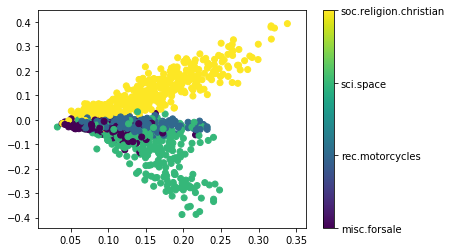

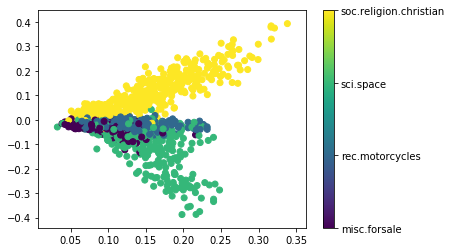

In [31]:
categories = ['rec.motorcycles','sci.space', 'soc.religion.christian','misc.forsale']

train_2 = fetch_20newsgroups(subset='train',categories=categories, shuffle=True, random_state=42)
count_vect_2 = CountVectorizer()
train_counts_2 = count_vect.fit_transform(train_2.data)
tfidf_transformer_2 = TfidfTransformer()
train_tfidf_2 = tfidf_transformer.fit_transform(train_counts_2)
clf = MultinomialNB().fit(train_tfidf_2, train_2.target)
test_2 = fetch_20newsgroups(subset='test',categories=categories)
test_counts_2 = count_vect.transform(test_2.data)
test_tfidf_2 = tfidf_transformer.transform(test_counts_2)
predicted_2 = clf.predict(test_tfidf_2)

print("accuracy : ",accuracy_score(test_2.target,predicted_2))

svd = TruncatedSVD(n_components=2)
SVD=svd.fit_transform(test_tfidf_2)
plt.figure()
plt.scatter(SVD[:,0],SVD[:,1],c=test_2.target)
formatter = plt.FuncFormatter(lambda i, args : test_2.target_names[int(i)])
plt.colorbar(ticks=[0,1,2,3],format=formatter)
plt.figure()
plt.scatter(SVD[:,0],SVD[:,1],c=predicted_2)
plt.colorbar(ticks=[0,1,2,3],format=formatter)

Les catégories parraissent bien classées par le modèle. Bien que l'on voit dans le deuxième graphique que certains points jaunes ("soc.religion.christian") sont predit là ou il ne sont pas normalement.

### GridSearch

Pour chaque modèle, il est possible de trouver les meilleurs paramètres afin d'avoir le meilleur score de classification. Pour cela, nous utilisons la méthode "GridSearch" qui consiste à tester plusieurs combinaisons de paramètres et de trouver la combinaison qui donne le meilleur score.

Cette étape étant très couteuse en temps, nous mettons le code et le résultat en commentaires :

### B. Stochastic Gradient Descent Classifier (SGD)

In [32]:
clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
clf.fit(train_tfidf, twenty_train.target)
predicted=clf.predict(test_tfidf)
SGD=accuracy_score(twenty_test.target,predicted)
print(SGD)

0.8498406797663304


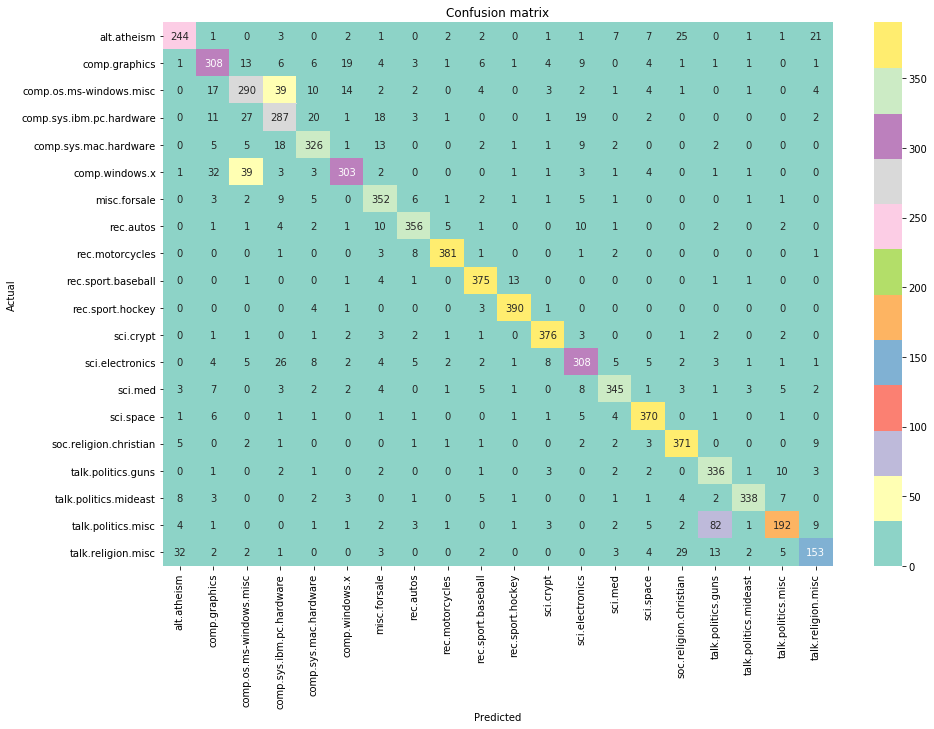

In [33]:
conf_mat = confusion_matrix(twenty_test.target, predicted)
labels=twenty_all.target_names
# Plot confusion_matrix
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(conf_mat, annot=True, cmap = "Set3", fmt ="d",
xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

Avec le modèle SGD, la matrice de confusion est différente. Les catégories que le modèle n'arrive pas à distinguer sont à peu près les mêmes, mais à des degrès différents.

### Décomposition SVD

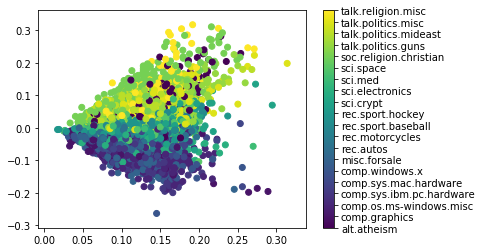

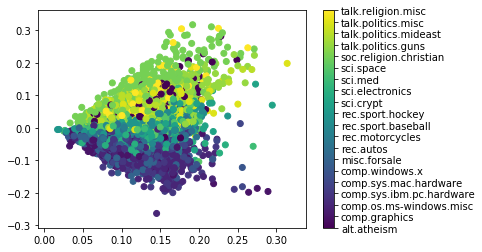

In [34]:
SVD=svd.fit_transform(test_tfidf)
plt.figure()
plt.scatter(SVD[:,0],SVD[:,1],c=twenty_test.target)
formatter = plt.FuncFormatter(lambda i, args : twenty_test.target_names[int(i)])
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)
plt.figure()
plt.scatter(SVD[:,0],SVD[:,1],c=predicted)
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)

### Décomposition NMF

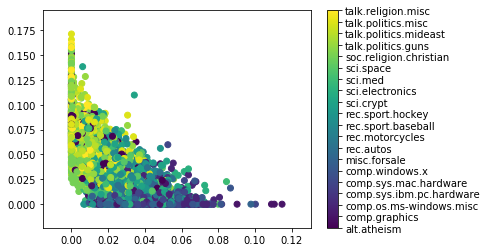

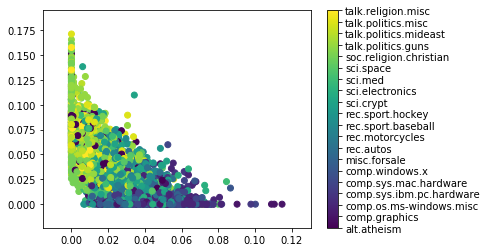

In [35]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=2)
NMF=nmf.fit_transform(test_tfidf)## A changer avec les vraies valeurs
plt.figure()
plt.scatter(NMF[:,0],NMF[:,1],c=twenty_test.target)
formatter = plt.FuncFormatter(lambda i, args : twenty_test.target_names[int(i)])
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)
plt.figure()
plt.scatter(NMF[:,0],NMF[:,1],c=predicted)
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)

#### GridSearch 

### C. k Nearest Neighbors (kNN)

La classification basée sur les k voisins les plus proche est un type d'apprentissage basé sur des instances ou d'apprentissage non généralisant: elle ne tente pas de construire un modèle interne général, mais stocke simplement des instances des données d'apprentissage.
La classification est calculée à partir d'un vote à la majorité simple des voisins les plus proches de chaque point: un point se voit attribuer la classe de données qui a le plus de représentants parmi les voisins les plus proches du point.

Calcul de la distance euclidienne : D_e(x, y) = sqrt{sum_{j=1}^{n} (x_j - y_j)^2}

In [36]:
clf = KNeighborsClassifier(weights='distance').fit(train_tfidf, twenty_train.target)
predicted = clf.predict(test_tfidf)
KNN = accuracy_score(twenty_test.target,predicted)
print(KNN)

0.6943706850770048


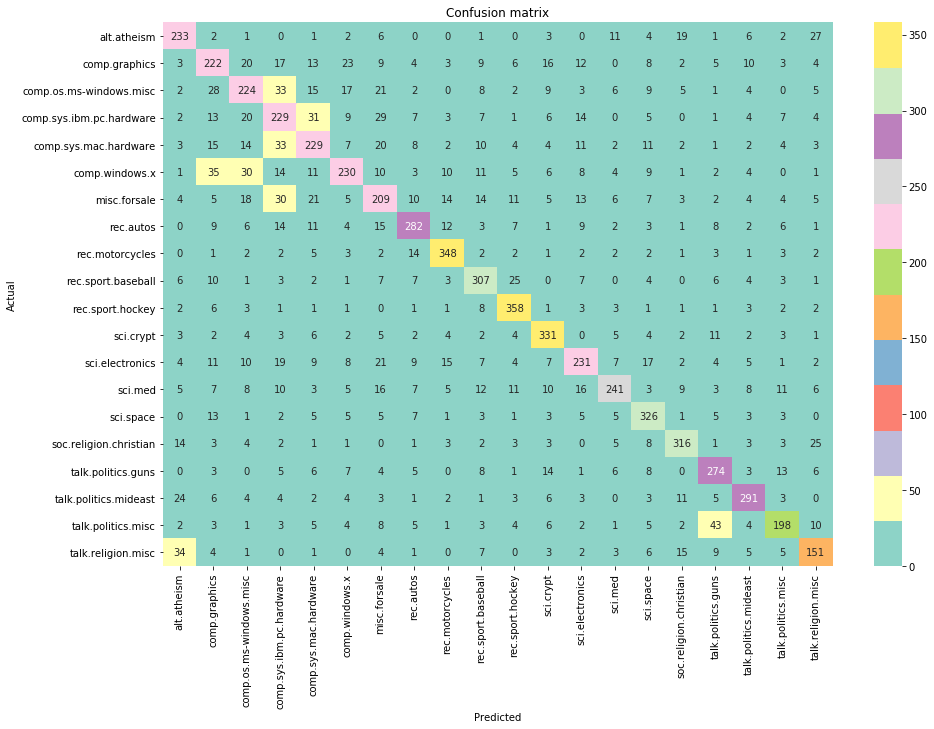

In [37]:
conf_mat = confusion_matrix(twenty_test.target, predicted)
labels=twenty_all.target_names
# Plot confusion_matrix
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(conf_mat, annot=True, cmap = "Set3", fmt ="d",
xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

### Décomposition SVD

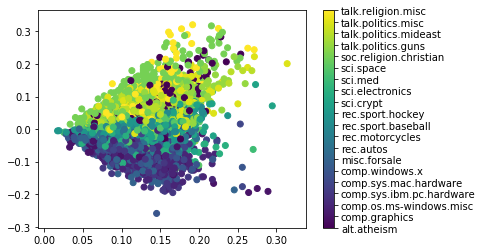

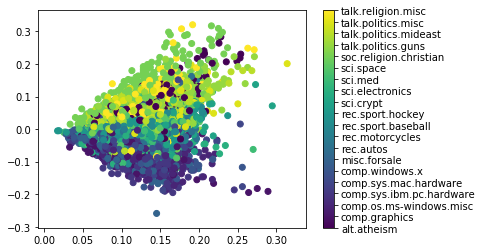

In [38]:
SVD=svd.fit_transform(test_tfidf)
plt.figure()
plt.scatter(SVD[:,0],SVD[:,1],c=twenty_test.target)
formatter = plt.FuncFormatter(lambda i, args : twenty_test.target_names[int(i)])
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)
plt.figure()
plt.scatter(SVD[:,0],SVD[:,1],c=predicted)
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)

### Décomposition NMF

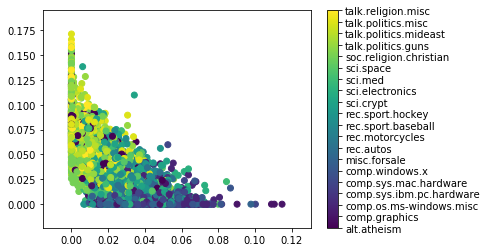

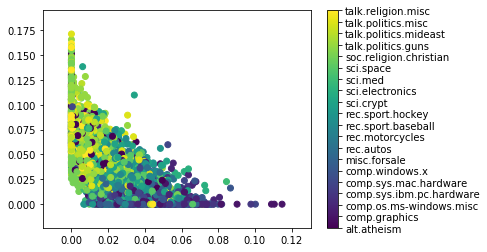

In [39]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=2)
NMF=nmf.fit_transform(test_tfidf)## A changer avec les vraies valeurs
plt.figure()
plt.scatter(NMF[:,0],NMF[:,1],c=twenty_test.target)
formatter = plt.FuncFormatter(lambda i, args : twenty_test.target_names[int(i)])
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)
plt.figure()
plt.scatter(NMF[:,0],NMF[:,1],c=predicted)
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)

#### Grid Search

### D. Régression logistique

In [40]:
clf = LogisticRegression(penalty='l2')
clf = clf.fit(train_tfidf, twenty_train.target)
predicted = clf.predict(test_tfidf)
Rlog = accuracy_score(twenty_test.target,predicted)
print(Rlog)

0.8321826872012745


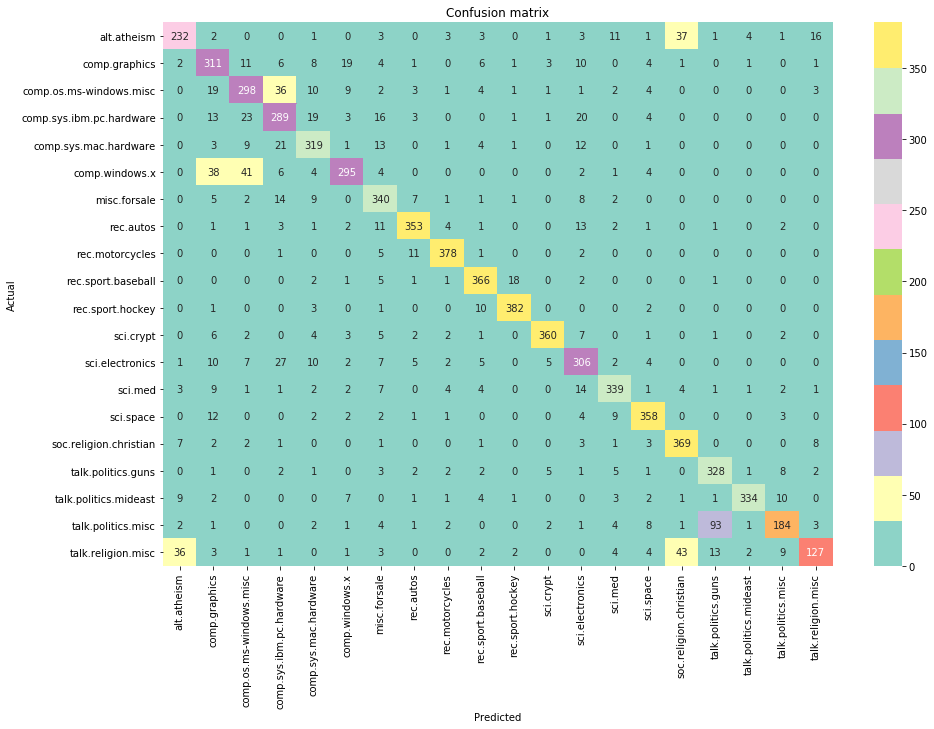

In [41]:
conf_mat = confusion_matrix(twenty_test.target, predicted)
labels = twenty_all.target_names
# Plot confusion_matrix
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(conf_mat, annot=True, cmap = "Set3", fmt ="d",
xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

### Décomposition SVD

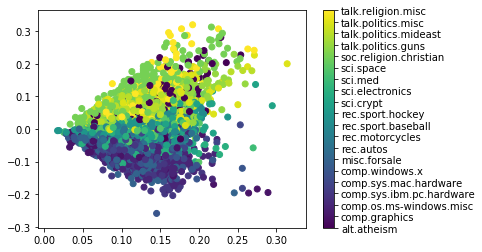

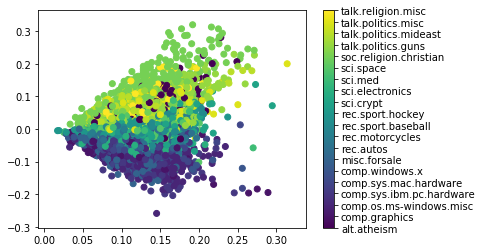

In [42]:
SVD=svd.fit_transform(test_tfidf)
plt.figure()
plt.scatter(SVD[:,0],SVD[:,1],c=twenty_test.target)
formatter = plt.FuncFormatter(lambda i, args : twenty_test.target_names[int(i)])
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)
plt.figure()
plt.scatter(SVD[:,0],SVD[:,1],c=predicted)
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)

### Décomposition NMF

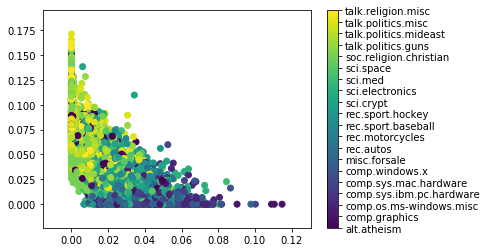

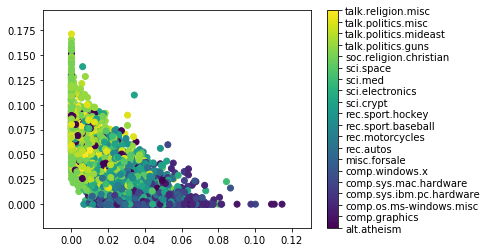

In [43]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=2)
NMF=nmf.fit_transform(test_tfidf)## A changer avec les vraies valeurs
plt.figure()
plt.scatter(NMF[:,0],NMF[:,1],c=twenty_test.target)
formatter = plt.FuncFormatter(lambda i, args : twenty_test.target_names[int(i)])
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)
plt.figure()
plt.scatter(NMF[:,0],NMF[:,1],c=predicted)
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)

#### Grid Search

### E. Decision Tree

Les arbres de décision (DT) sont une méthode d'apprentissage supervisé non paramétrique utilisée pour la classification et la régression. L'objectif est de créer un modèle qui prédit la valeur d'une variable cible en apprenant des règles de décision simples déduites des caractéristiques des données.

Par exemple les arbres de décision apprennent à partir des données à se rapprocher d'une courbe sinusoïdale avec un ensemble de règles de décision "if-then-else". Plus l'arbre est profond, plus les règles de décision sont complexes et plus le modèle est adapté.

In [44]:
clf = tree.DecisionTreeClassifier(criterion='gini')
clf = clf.fit(train_tfidf, twenty_train.target)
predicted = clf.predict(test_tfidf)
DT = accuracy_score(twenty_test.target,predicted)
print(DT)

0.567578332448221


In [45]:
import graphviz #EXPORT DE L'ARBRE PRODUIT EN PDF POUR UNE MEILLEURE VISUALISATION
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("DT") 

'DT.pdf'

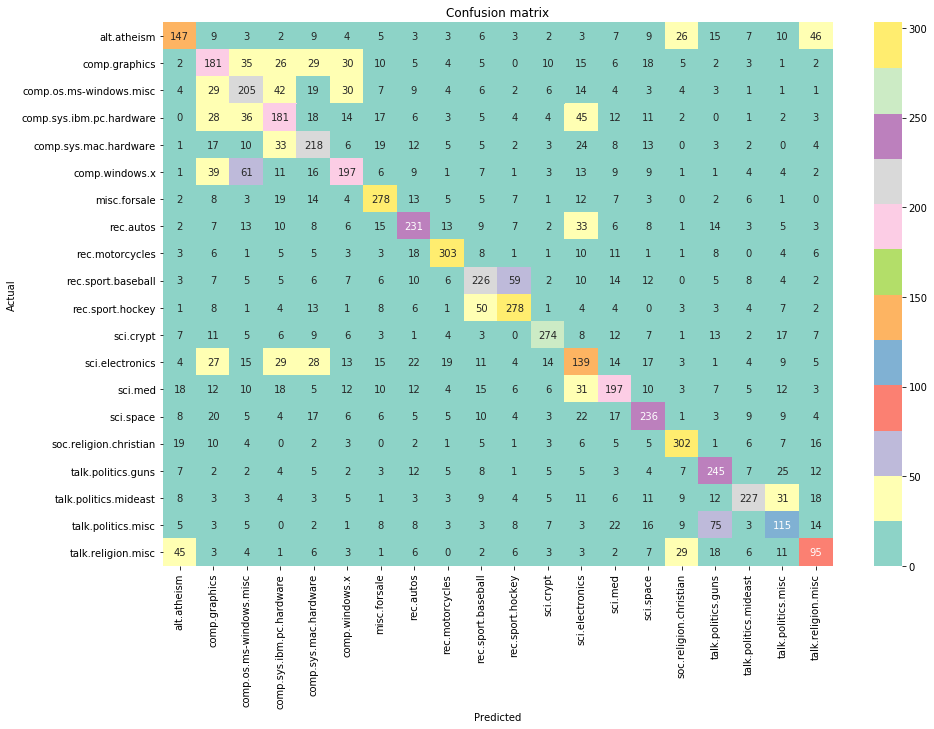

In [46]:
conf_mat = confusion_matrix(twenty_test.target, predicted)
labels=twenty_all.target_names
# Plot confusion_matrix
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(conf_mat, annot=True, cmap = "Set3", fmt ="d",
xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

### Décomposition SVD

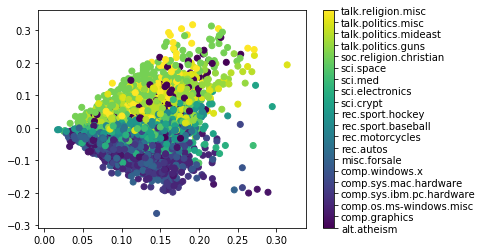

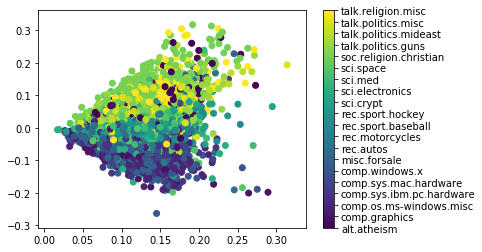

In [47]:
SVD=svd.fit_transform(test_tfidf)
plt.figure()
plt.scatter(SVD[:,0],SVD[:,1],c=twenty_test.target)
formatter = plt.FuncFormatter(lambda i, args : twenty_test.target_names[int(i)])
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)
plt.figure()
plt.scatter(SVD[:,0],SVD[:,1],c=predicted)
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)

### Décomposition NMF

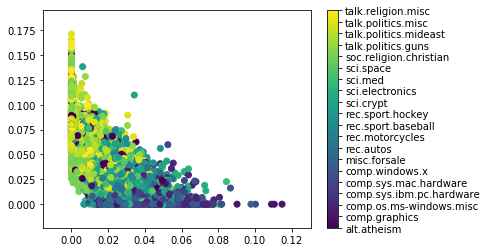

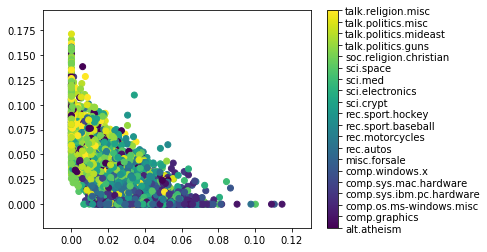

In [48]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=2)
NMF=nmf.fit_transform(test_tfidf)## A changer avec les vraies valeurs
plt.figure()
plt.scatter(NMF[:,0],NMF[:,1],c=twenty_test.target)
formatter = plt.FuncFormatter(lambda i, args : twenty_test.target_names[int(i)])
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)
plt.figure()
plt.scatter(NMF[:,0],NMF[:,1],c=predicted)
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)

#### Grid Search

### F. Linear Support Vector Classification (SVC)

Une machine à vecteurs de support construit un hyperplan ou un ensemble d'hyperplan dans un espace de dimension élevée ou infinie, qui peut être utilisé pour la classification, la régression ou d'autres tâches. Intuitivement, une bonne séparation est obtenue par l'hyperplan qui a la plus grande distance aux points de données d'entraînement les plus proches de n'importe quelle classe (soi-disant marge fonctionnelle), car en général plus la marge est grande, plus l'erreur de généralisation du classificateur est faible.

In [49]:
clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(train_tfidf, twenty_train.target)
predicted=clf.predict(test_tfidf)
SVC = accuracy_score(twenty_test.target,predicted)
print(SVC)

0.851035581518853


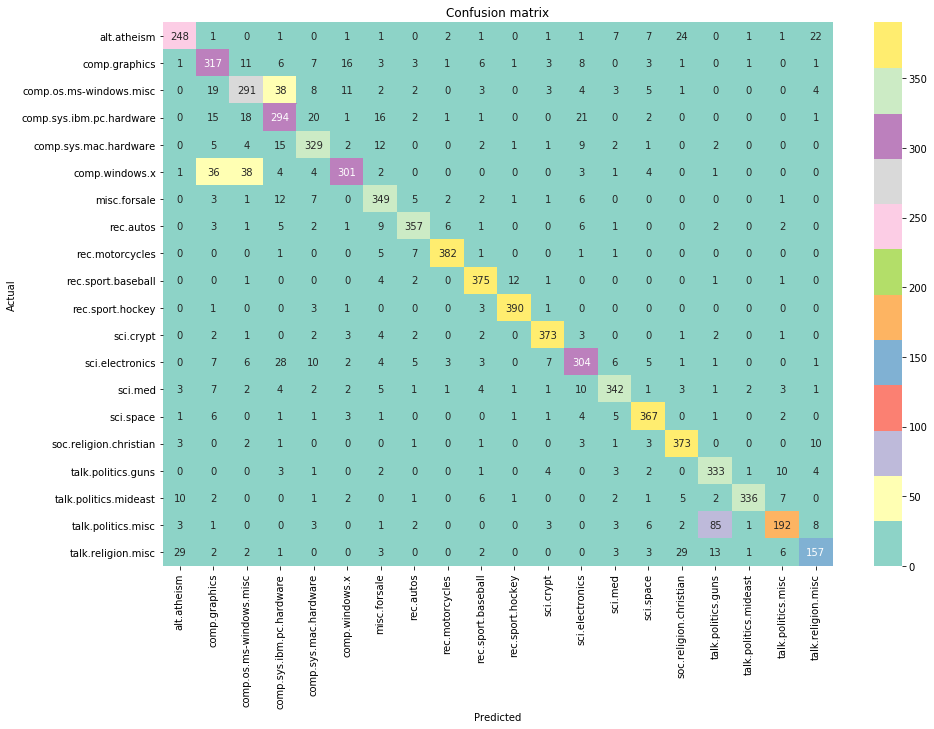

In [50]:
conf_mat = confusion_matrix(twenty_test.target, predicted)
labels=twenty_all.target_names
# Plot confusion_matrix
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(conf_mat, annot=True, cmap = "Set3", fmt ="d",
xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

### Décomposition SVD

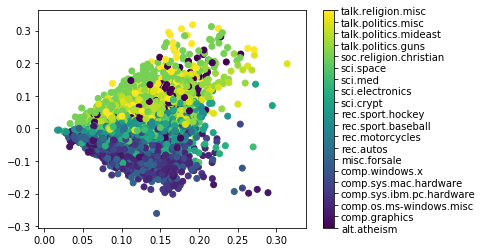

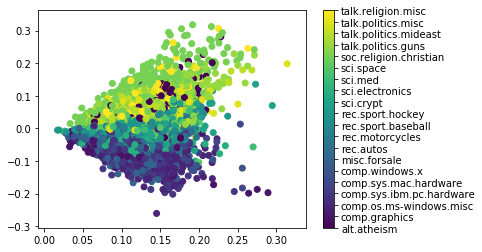

In [51]:
SVD=svd.fit_transform(test_tfidf)
plt.figure()
plt.scatter(SVD[:,0],SVD[:,1],c=twenty_test.target)
formatter = plt.FuncFormatter(lambda i, args : twenty_test.target_names[int(i)])
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)
plt.figure()
plt.scatter(SVD[:,0],SVD[:,1],c=predicted)
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)

### Décomposition NMF

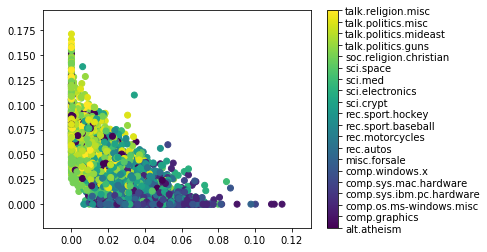

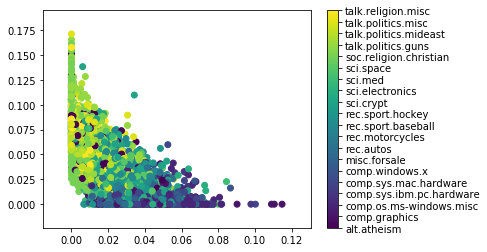

In [52]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=2)
NMF=nmf.fit_transform(test_tfidf)## A changer avec les vraies valeurs
plt.figure()
plt.scatter(NMF[:,0],NMF[:,1],c=twenty_test.target)
formatter = plt.FuncFormatter(lambda i, args : twenty_test.target_names[int(i)])
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)
plt.figure()
plt.scatter(NMF[:,0],NMF[:,1],c=predicted)
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)

### G. Régression linéaire

Cela n'aurait aucun sens de faire de la régression linéaire sur des données textuelles (même après transformation TF-IDF). En effet, on ne pourrait pas prédire un mot. 
Nous avons donc décidé d'appliquer la régression linéaire sur les données après décomposition SVD. La regression est donc utilisée pour prédire un vecteur propre. 

Coefficients: 
 [0.55318677]
Mean squared error: 0.00
Coefficient of determination: 0.27


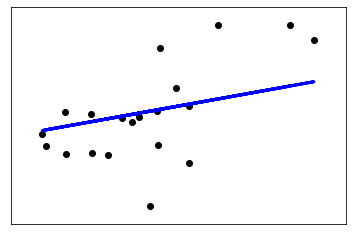

In [54]:
X=SVD[:,0] 
y=SVD[:,1] 

X_train = X[:-20]
X_train=np.vstack(X_train)

X_test = X[-20:]
X_test=np.vstack(X_test)

y_train = y[:-20]
y_test = y[-20:]
y_train.reshape(-1,1)
y_test.reshape(-1,1)

#modèle
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test,y_pred))

# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

Pour évaluer les performances de la régression linéaire, il faut regarder la mesure "Mean squared error" et la repartition des points autour de la droite de regression.

Ici, Mean squared error n'est pas egal à 0 mais très proche (il faudrait regarder avec plus de valeurs siginificatives). De plus, les points sont plutôt bien répartis autour de la droite. 
On en conclut donc que, bien que predire un vecteur propre n'est pas très intuitif, la régression linéaire est un modèle qui marche bien.

### H - Perceptron

Le perceptron est un algorithme d'apprentissage supervisé qui utilise un ensemble de fonctions pour apprendre des entrées afin de déterminer si elles appartiennent à une classe ou non. C'était l'une des premières techniques d'apprentissage automatique utilisées et elle est toujours au centre de nombreux réseaux de neurones modernes.

Le perceptron prend un vecteur d'entrée x, le multiplie par un vecteur de poids correspondant w, puis ajoute un biais b. Il utilise ensuite une fonction d'activation, (la fonction step, dans ce cas), pour déterminer si notre somme résultante est supérieure à 0, afin de la classer comme 1 ou 0.

                f(x) = 1 si w*x+b > 0
                     = 0 sinon

In [55]:
clf = Perceptron(max_iter=1000, random_state=11)
clf.fit(train_tfidf,twenty_train.target)
predictions = clf.predict(test_tfidf)
PERC = accuracy_score(twenty_test.target,predictions)
print(classification_report(twenty_test.target,predictions))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76       319
           1       0.73      0.74      0.74       389
           2       0.73      0.65      0.69       394
           3       0.72      0.68      0.70       392
           4       0.81      0.79      0.80       385
           5       0.84      0.70      0.76       395
           6       0.83      0.83      0.83       390
           7       0.85      0.82      0.83       396
           8       0.84      0.92      0.88       398
           9       0.87      0.88      0.88       397
          10       0.93      0.92      0.93       399
          11       0.81      0.93      0.87       396
          12       0.72      0.68      0.70       393
          13       0.78      0.81      0.79       396
          14       0.87      0.87      0.87       394
          15       0.82      0.86      0.84       398
          16       0.68      0.88      0.77       364
          17       0.91    

### I. Comparaison

In [56]:
accuracy_tfidf = [['MNB', MNB],['SGD',SGD], ['KNN',KNN], ['Rég.Logistique',Rlog], ['Decision Tree', DT], ['SVC', SVC], ['Perceptron', PERC]]
comp1 = pd.DataFrame(accuracy_tfidf, columns =['Classifieurs', 'Best Score'])

In [57]:
size = [MNB,SGD,KNN,Rlog,DT,SVC,PERC]

import plotly.graph_objects as go
fig = go.Figure(data=[go.Scatter(
    x=comp1["Classifieurs"], y=comp1["Best Score"],
    mode='markers',
    marker=dict(
        size=size,
        sizemode='area',
        sizeref=2.*max(size)/(40.**2),
        sizemin=4
    ))
])
fig.update_layout(
    title="Comparaison des différents modèles d'apprentissage supervisé",
    xaxis_title="Modèle",
    yaxis_title="Accuracy",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

On remarque sur le dataset 20newsgroups c'est le modèle Linear Support Vector Classification (SVC) qui obtient la précision la plus importante (0,85) et l'arbre de décision la plus faible.
Le fait que l'arbre de décision ne classifie pas bien les données parait assez logique car il n'est pas très intuitif même pour nous d'établir des règles de décisions.

### J. K Means

### 1) Premier modèle K means

In [59]:
kmeans = KMeans().fit(train_tfidf,twenty_train.target)
predicted = kmeans.predict(test_tfidf)

Comme Kmeans est un modèle d'apprentissage non supervisé, cela n'a pas de sens de calculer l'accuracy.
Il y a plusieurs méthodes pour évaluer les performances de Kmeans. 
La plus performante, à notre connaissance est la méthode de l'indice de Silhouette. 
Nous regardons donc pour quel nombre de cluster, l'indice de silhouette est le meilleur.

[0.00038717155886698097, 0.0018342449104296022, 0.002003003043676055, 0.0006627706802145496, 0.001270765408477048, -0.0004079910023318256, 0.0012011351733781709, 0.0016357862772426069, 0.0023327077898478606, 0.0011809508647015845, -0.002982775132791218, -0.006668932229817467, -0.003451008634649759, -0.008032739160880344, -0.004206946278400885, -0.002142681409264922, -0.004296107819632622, -0.004682562522741673]


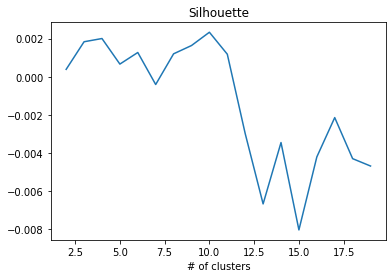

In [60]:
res=[]
for k in range(2,20):
    #MiniBatchKMeans pour executer en parallèle
    km= MiniBatchKMeans(n_clusters=k).fit_predict(test_tfidf)
    res.append(silhouette_score(test_tfidf,km))
print(res)

#graphique
plt.title("Silhouette") 
plt.xlabel("# of clusters") 
plt.plot(range(2,20,1),res) 
plt.show()

On observe grâce à l'indice de silhouete que le score est meilleur quand le nombre de cluster est 10. 
Seulement, on sait aussi que l'indice de Silhouette ne donne pas beaucoup d'informations quand le nombre de dimensions est trop grand (Concentration of Measure / Curse of Dimmensionality) .
C'est pourquoi nous allons réduire les dimensions avec SVD puis NMF, appliquer Kmeans sur les "nouvelles données" et l'évaluer grâce à différentes mésures.

### 2) K Means avec réduction dimensionnelle SVD

Après avoir procédé à la décomposition SVD, nous évaluons notre modèle à l'aide de plusieurs mesures dont nous comparons l'effacité.
Ces mesures sont : 
- l'indice de silhouette
- la méthode Elbow
- Homogeneity
- Completeness
- V-measure
- Adjusted Rand-Index
- Silhouette Coefficient

#### Nombre idéal de cluster avec la méthode Elbow

inertia_ : La somme des carées des distances jusqu'au centre du cluster le plus proche

In [61]:
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer, InterclusterDistance

In [62]:
inertia_list=[]
X = all_tfidf
labels = twenty_all.target

svd = TruncatedSVD(2)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X = lsa.fit_transform(X)

for i in range(1,20):
    model = KMeans(n_clusters=i, init='k-means++', n_init=1)
    model.fit(X)
    inertia_list.append(model.inertia_)
    print('N°'+str(i)+" "+str(model.inertia_))
    
x = np.array(range(1,20))
fig = go.Figure(data=go.Scatter(x=x,y=inertia_list))
fig.update_layout(title='Inertia score for KMeans Clustering',
                   xaxis_title='Nombre de cluster',
                   yaxis_title='Inertie')
fig.show()

N°1 2821.420144495775
N°2 990.43930775013
N°3 461.1594505943779
N°4 277.18675140124367
N°5 182.83279261017762
N°6 130.75977375917952
N°7 98.29331617628391
N°8 78.28705694918095
N°9 61.90212067872275
N°10 50.42437964311269
N°11 42.037506947457985
N°12 35.76658355156307
N°13 30.304803827466365
N°14 26.828470276987932
N°15 23.021220874350366
N°16 20.79768726763674
N°17 18.24475891269752
N°18 16.35562683593021
N°19 14.709430840899572


Le score d'inertie indique 5 comme nombre de clusters idéal pour notre modèle, regardons avec la méthode silhouette.

#### Nombre idéal de cluster avec différentes mesures d'évaluation

In [63]:
clusters = [2,3,4,5,6,8,10]
for c in clusters:
    km = MiniBatchKMeans(n_clusters=c, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000)
    km.fit(X)
    print(f"Pour {c} clusters :")
    print("       Homogeneity: %0.3f" % homogeneity_score(labels, km.labels_))
    print("       Completeness: %0.3f" % completeness_score(labels, km.labels_))
    print("       V-measure: %0.3f" % v_measure_score(labels, km.labels_))
    print("       Adjusted Rand-Index: %.3f" % adjusted_rand_score(labels, km.labels_))
    print("       Silhouette Coefficient: %0.3f" % silhouette_score(X, km.labels_, sample_size=1000))

Pour 2 clusters :
       Homogeneity: 0.109
       Completeness: 0.482
       V-measure: 0.177
       Adjusted Rand-Index: 0.050
       Silhouette Coefficient: 0.561
Pour 3 clusters :
       Homogeneity: 0.168
       Completeness: 0.473
       V-measure: 0.248
       Adjusted Rand-Index: 0.085
       Silhouette Coefficient: 0.574
Pour 4 clusters :
       Homogeneity: 0.183
       Completeness: 0.405
       V-measure: 0.252
       Adjusted Rand-Index: 0.084
       Silhouette Coefficient: 0.537
Pour 5 clusters :
       Homogeneity: 0.194
       Completeness: 0.386
       V-measure: 0.258
       Adjusted Rand-Index: 0.089
       Silhouette Coefficient: 0.533
Pour 6 clusters :
       Homogeneity: 0.204
       Completeness: 0.354
       V-measure: 0.259
       Adjusted Rand-Index: 0.089
       Silhouette Coefficient: 0.533
Pour 8 clusters :
       Homogeneity: 0.210
       Completeness: 0.310
       V-measure: 0.250
       Adjusted Rand-Index: 0.087
       Silhouette Coefficient: 0.520
Pour

Le coefficient silhouette paraît être le plus exacte avec un nombre de clusters de 2.

#### Méthode Silhouette

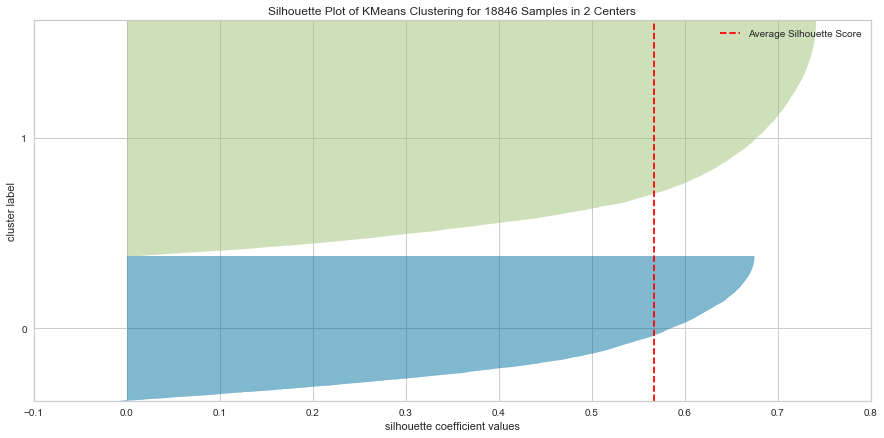

Silhouette score: 0.5668286514961283


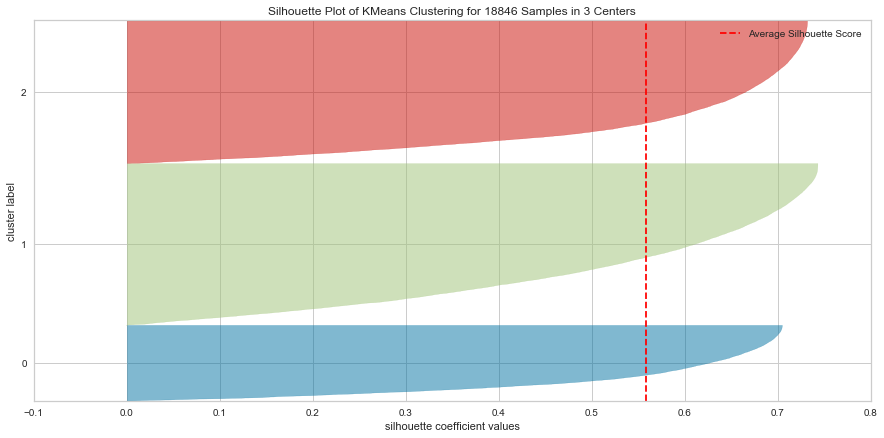

Silhouette score: 0.5579092967507735


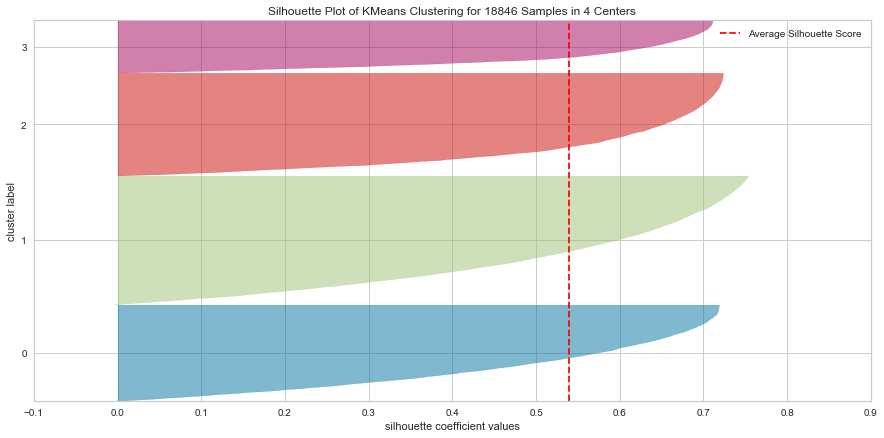

Silhouette score: 0.5390053041617004


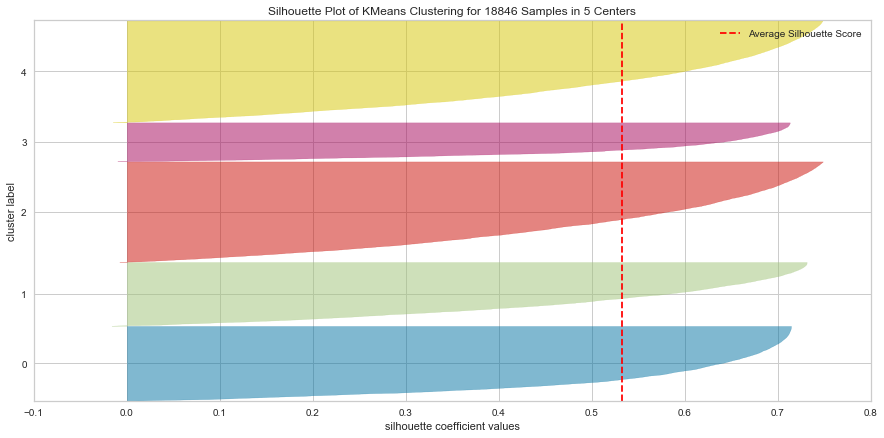

Silhouette score: 0.5328129956845639


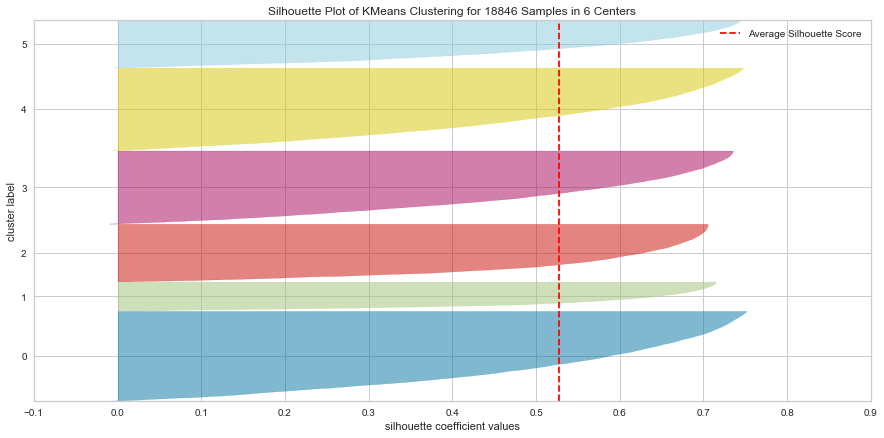

Silhouette score: 0.5277663205559939


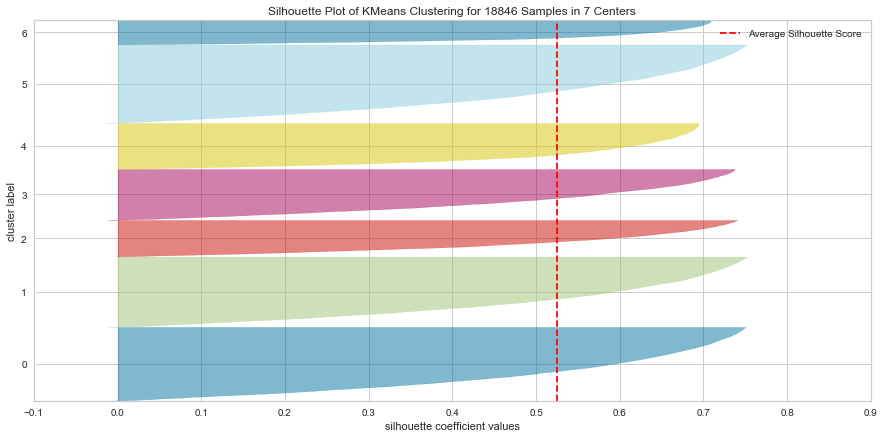

Silhouette score: 0.5249708943904893


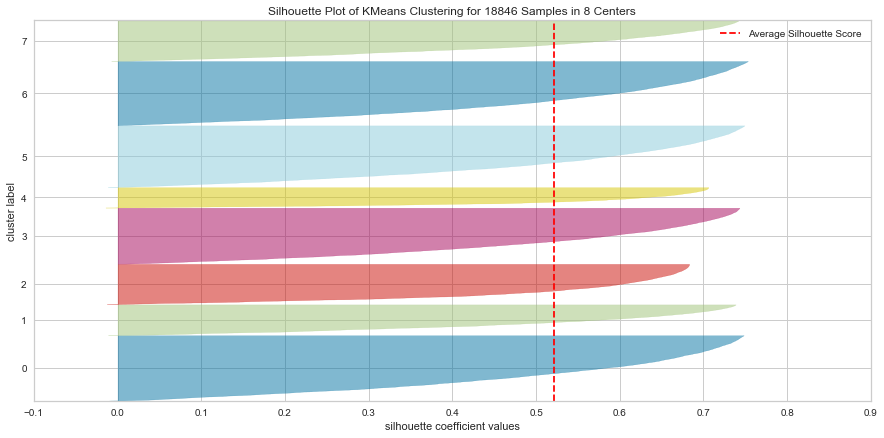

Silhouette score: 0.5213656594882862


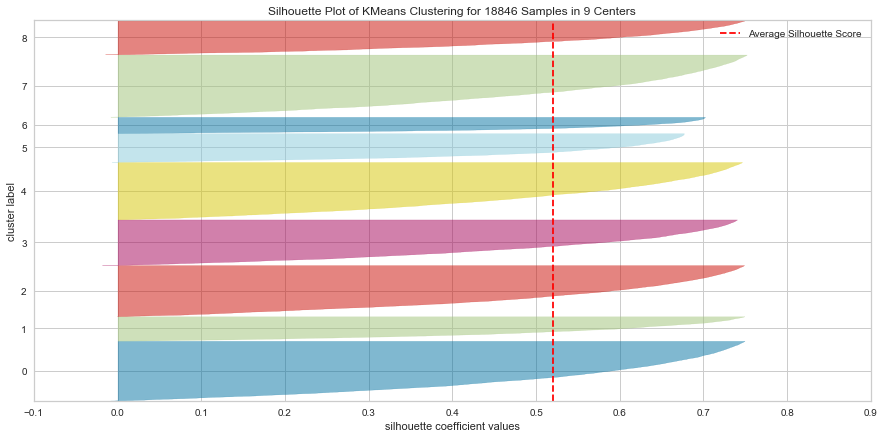

Silhouette score: 0.5204975056584557


In [64]:
for c in range(2,10):
    model_km = KMeans(algorithm='full', n_clusters=c)
    fig, ax = plt.subplots(figsize=(15,7))
    visualizer = SilhouetteVisualizer(model_km,colors='yellowbrick',ax=ax)
    visualizer.fit(X)
    visualizer.show()
    print("Silhouette score:", visualizer.silhouette_score_)

Avec la méthode Silhouette, la densité de répartition dans les deux clusters est beaucoup trop inégale. Nous alons alors utiliser la méthode du coude.

#### Elbow méthode

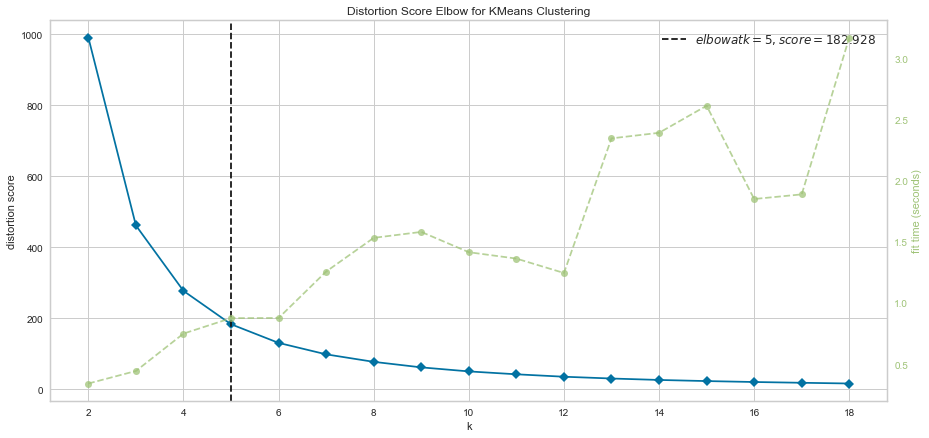

In [65]:
model_km = KMeans(algorithm='full')
fig, ax = plt.subplots(figsize=(15,7))
visualizer = KElbowVisualizer(model_km,k=(2,19),ax=ax)
visualizer.fit(X)
visualizer.show()

### Conclusion : 
    
    Méthode du coude : nombre de clusters = 5
    Silhouette méthode : nombre de clusters = 2
        

Le score d'inertie indiquait un nombre de clusters de 5 nous avons voulu comparer avec la méthode de silhouette or le coefficient silhouette n’est pas très bon sur des datasets avec beaucoup de dimension comme le texte (Concentration of Measure / Curse of Dimensionality). Mais un dernier calcul avec la méthode du coude (Elbow) confirme que le nombre de clusters est bien de 5 pour notre modèle et nos données.

### 3) KMeans avec réduction dimensionnelle NMF

In [66]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=2)
NMF = nmf.fit_transform(all_tfidf) 

In [67]:
X = NMF

for i in range(1,20):
    model = KMeans(n_clusters=i, init='k-means++', n_init=1)
    model.fit(X)
    inertia_list.append(model.inertia_)
    print('N°'+str(i)+" "+str(model.inertia_))
    
x = np.array(range(1,20))
fig = go.Figure(data=go.Scatter(x=x,y=inertia_list))
fig.update_layout(title='Inertia score for KMeans Clustering',
                   xaxis_title='Nombre de cluster',
                   yaxis_title='Inertie')
fig.show()

N°1 11.532153866227095
N°2 4.2733194899148605
N°3 2.765360986251493
N°4 2.0874290620419
N°5 1.5526161335787858
N°6 1.2874568303646095
N°7 1.1148314890453324
N°8 0.9580423671908678
N°9 0.843757618098799
N°10 0.7615957644274352
N°11 0.6990928506028646
N°12 0.651065937307362
N°13 0.5816696186159771
N°14 0.5430124068583383
N°15 0.5089066396265276
N°16 0.47398885047715134
N°17 0.4517434466339131
N°18 0.4276687699238045
N°19 0.39782893952994597


Sur ces données le nombre de cluster est toujours 5.

#### Méthode Silhouette

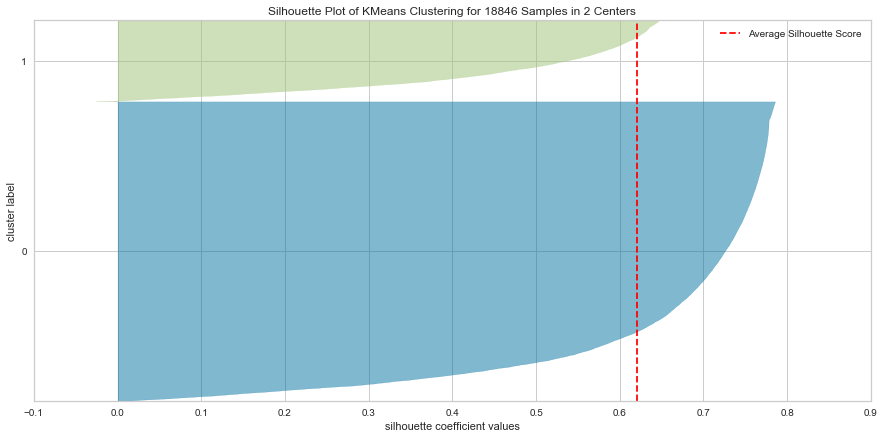

Silhouette score: 0.6202786147637396


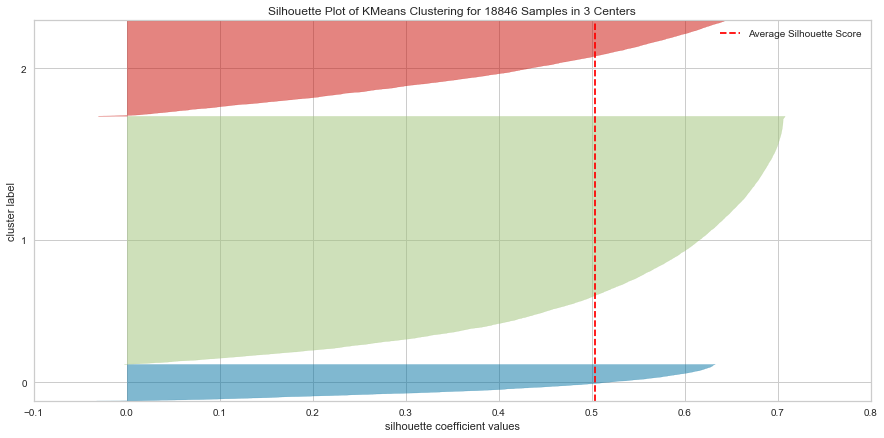

Silhouette score: 0.5031170329291467


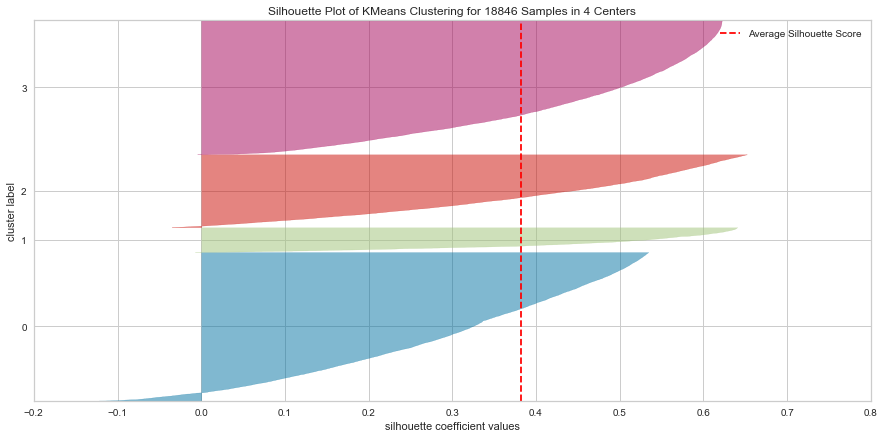

Silhouette score: 0.3816199749571016


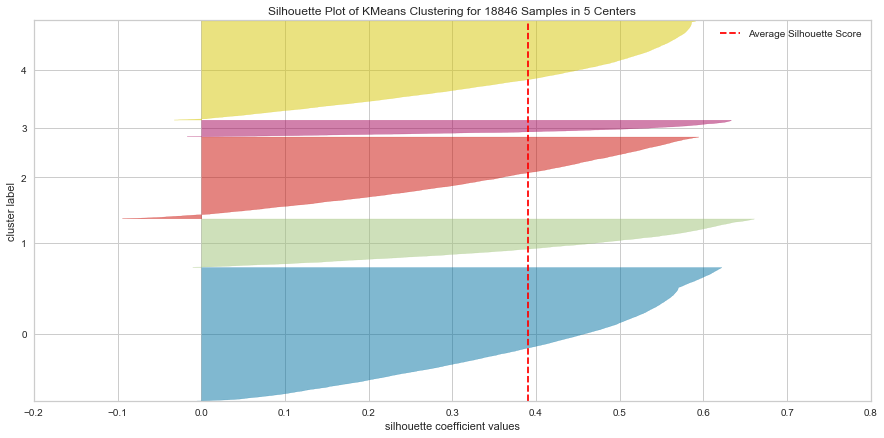

Silhouette score: 0.38992100139000824


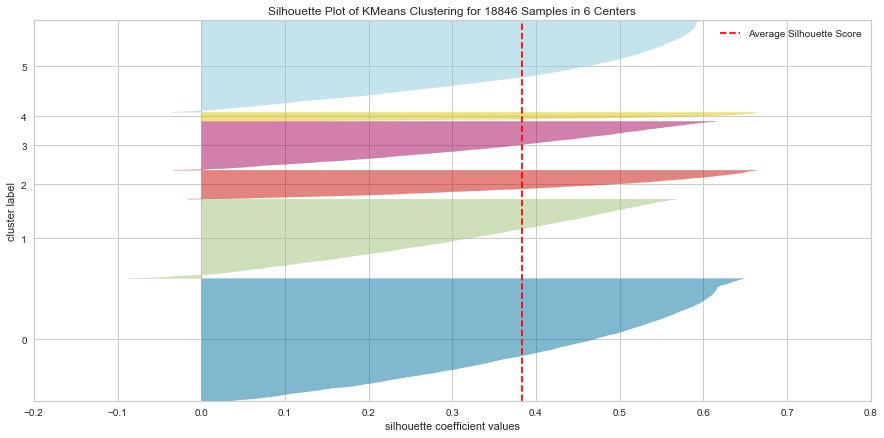

Silhouette score: 0.3827764595886445


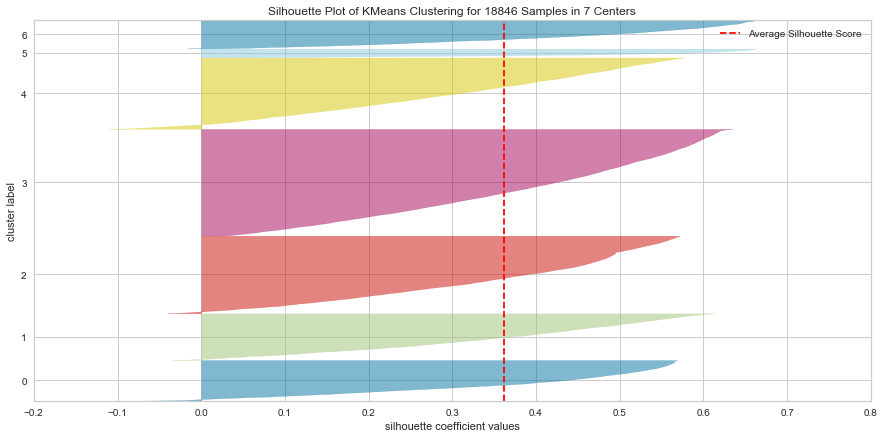

Silhouette score: 0.36136648917293873


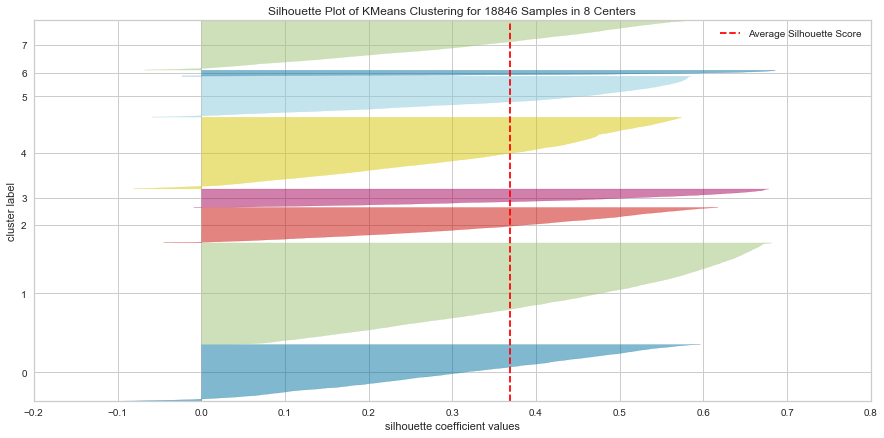

Silhouette score: 0.3693682649184152


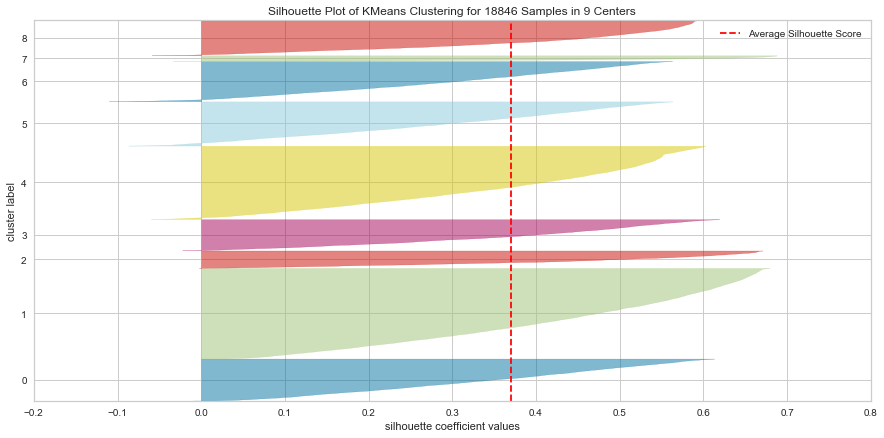

Silhouette score: 0.36992933726083815


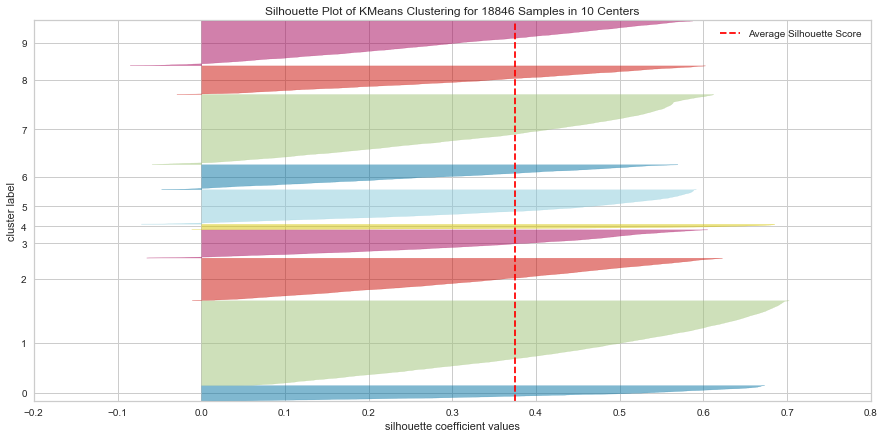

Silhouette score: 0.3750863441013141


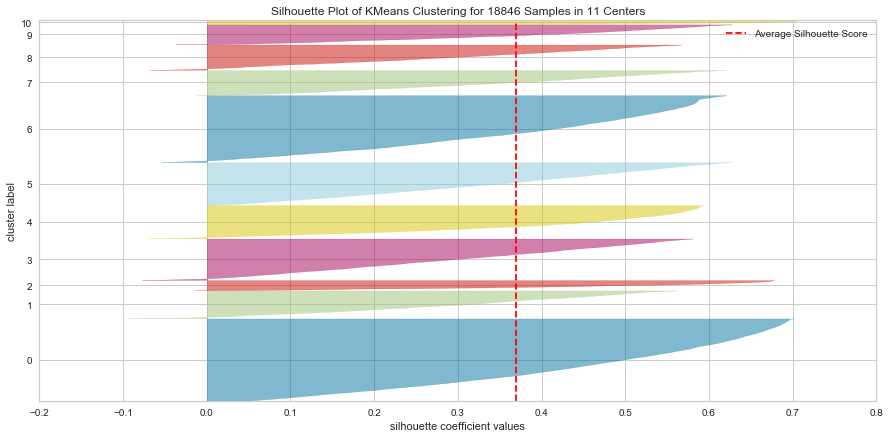

Silhouette score: 0.3700797817047017


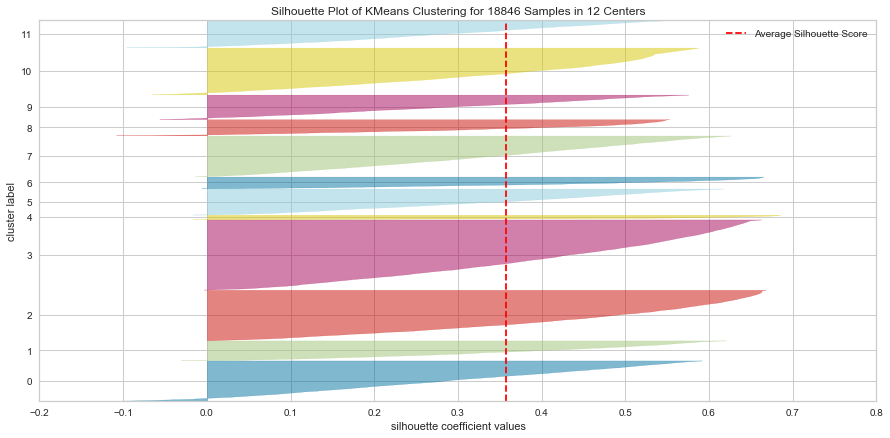

Silhouette score: 0.3573585707297523


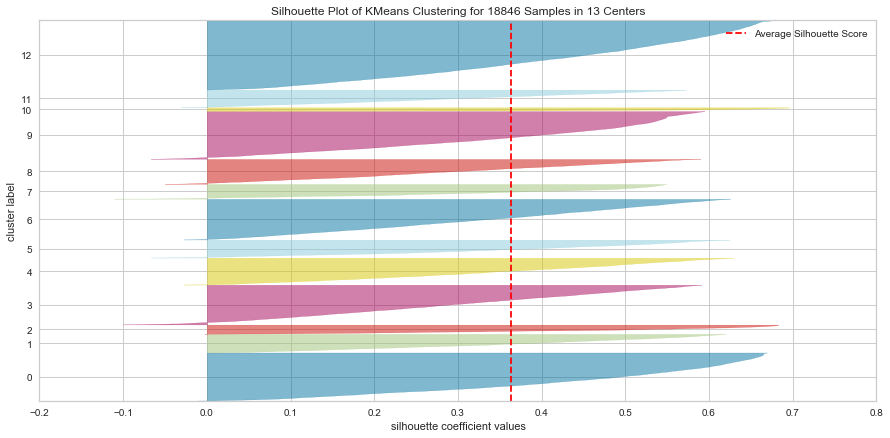

Silhouette score: 0.3639160028581601


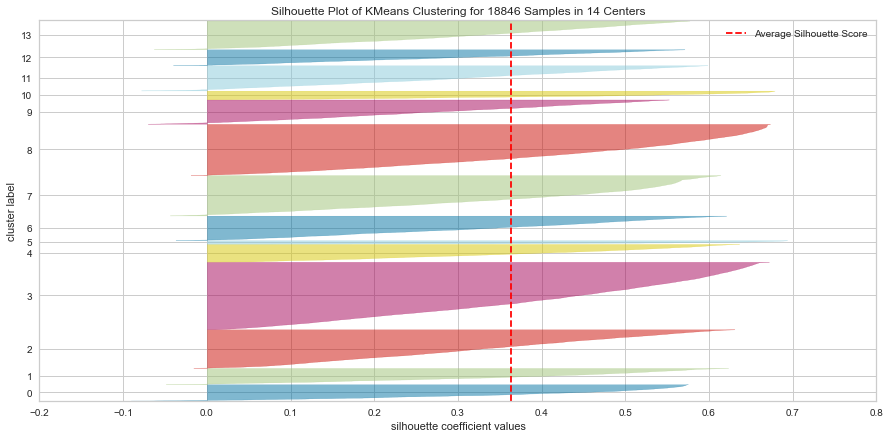

Silhouette score: 0.36375605417352147


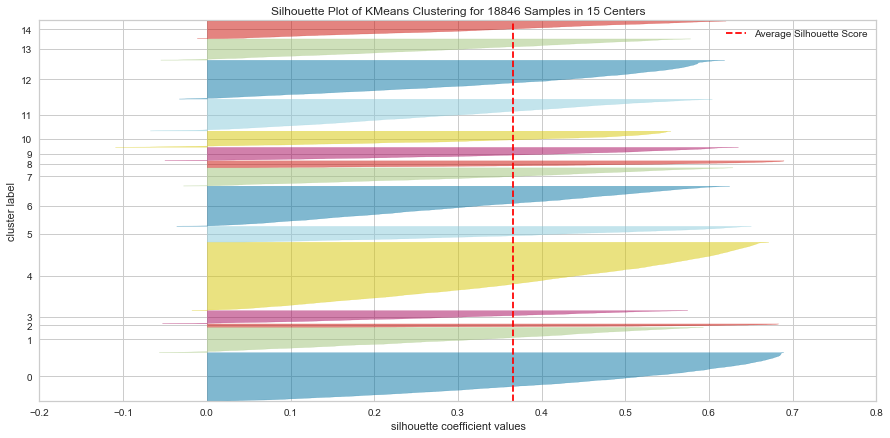

Silhouette score: 0.3660666276349568


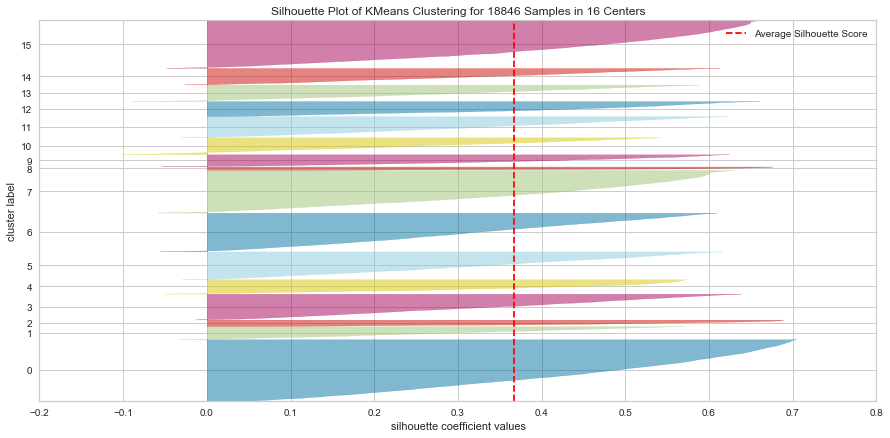

Silhouette score: 0.36713433976868837


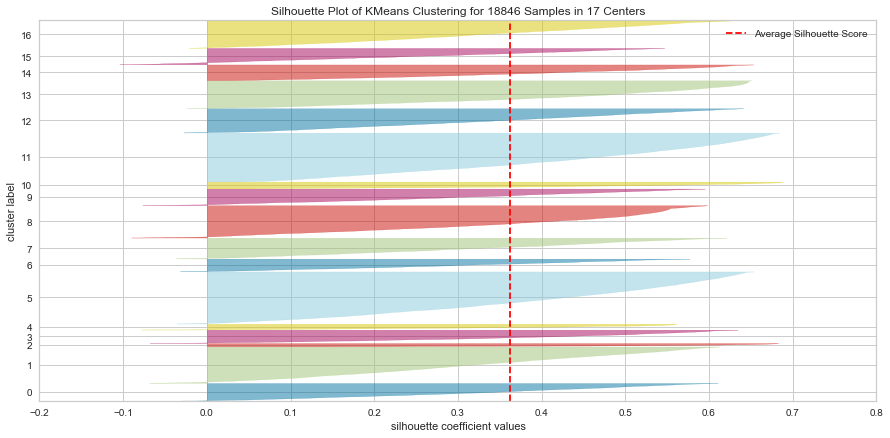

Silhouette score: 0.3619562839145583


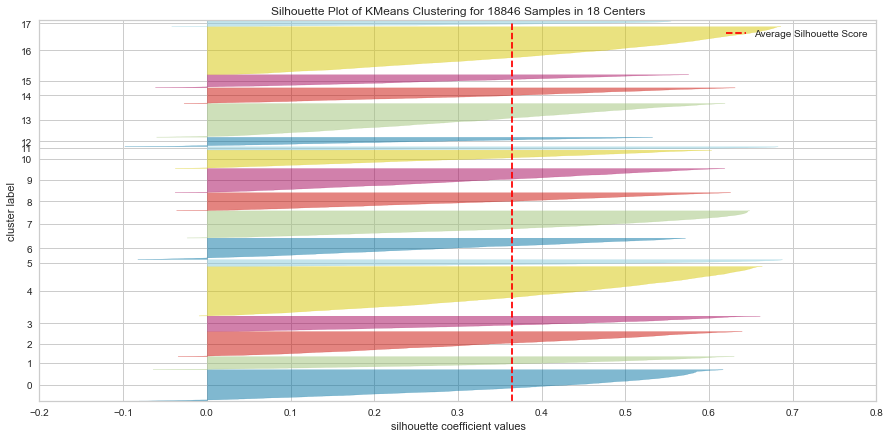

Silhouette score: 0.3643454064552973


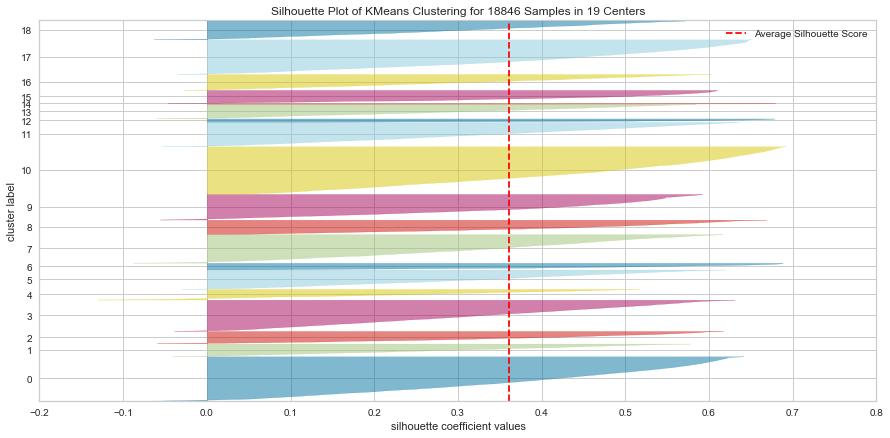

Silhouette score: 0.36048064035810456


In [68]:
for c in range(2,20):
    model_km = KMeans(algorithm='full', n_clusters=c)
    fig, ax = plt.subplots(figsize=(15,7))
    visualizer = SilhouetteVisualizer(model_km,colors='yellowbrick',ax=ax)
    visualizer.fit(X)
    visualizer.show()
    print("Silhouette score:", visualizer.silhouette_score_)

Ici la densité de répartition est encore plus flagrante entre les deux clusters avec le meilleure coefficient de silhouette.
Cette méthode n'est donc pas exacte avec les données (après NMF) non plus.

#### Elbow méthode

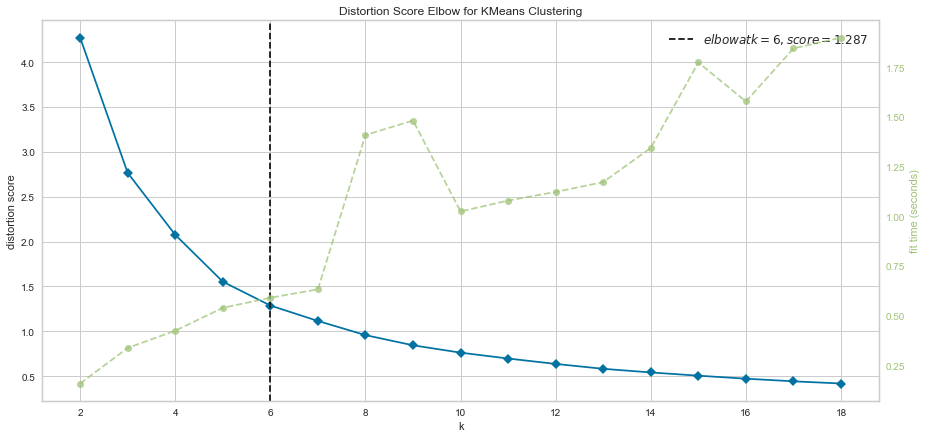

In [69]:
model_km = KMeans(algorithm='full')
fig, ax = plt.subplots(figsize=(15,7))
visualizer = KElbowVisualizer(model_km,k=(2,19),ax=ax)
visualizer.fit(X)
visualizer.show()

### Conclusion : 

Même observation que précedament avec les données tf-idf:
    
    Méthode du coude : nombre de clusters = 6
    Silhouette méthode : nombre de clusters = 2
        
        
Le coefficient silhouette n’est pas très bon sur des datasets avec beaucoup de dimension comme le texte (Concentration of Measure / Curse of Dimensionality).
Nous pouvons alors conclure que le nombre de clusters idéaux est 6 calculé avec la méthode du coude.

## Autres transformations

### Transformation HashingVectorizer

Le principe de HashingVectorizer est de convertir un ensemble de documents textuels en une matrice d'occurrences symboliques.

Il transforme un ensemble de documents textuels en une matrice scipy.sparse contenant des comptes d'occurrences des mots (ou des informations binaires sur les occurrences).

Cette implémentation de vectorisation de texte utilise l'astuce du hachage pour trouver le nom de la chaîne de caractères du jeton afin d'obtenir un index des nombres entiers.

Cette stratégie présente plusieurs avantages :

- Elle est très peu gourmande en mémoire et peut être adaptée à de grands ensembles de données car il n'est pas nécessaire de stocker un dictionnaire de vocabulaire en mémoire
- Elle est rapide à décortiquer et à décortiquer car elle ne contient aucun autre état que les paramètres du constructeur
- Elle peut être utilisée dans un pipeline en continu (ajustement partiel) ou en parallèle car aucun état n'est calculé pendant l'ajustement.

Il y a également quelques inconvénients (par rapport à l'utilisation d'un CountVectorizer avec un vocabulaire en mémoire) :

- il n'y a aucun moyen de calculer la transformation inverse (des indices de caractéristiques aux noms de caractéristiques des chaînes de caractères), ce qui peut poser un problème lorsqu'on essaie de déterminer quelles caractéristiques sont les plus importantes pour un modèle.

- il peut y avoir des collisions : des jetons distincts peuvent être mis en correspondance avec le même index de caractéristiques. Cependant, dans la pratique, cela pose rarement un problème si $n_features$ est suffisamment grand (par exemple 2 ** 18 pour les problèmes de classification de texte).

- pas de pondération IDF car cela rendrait le transformateur inutilisable.




In [70]:
from sklearn.feature_extraction.text import HashingVectorizer
vectorizer = HashingVectorizer(n_features=20)
vector_train = vectorizer.transform(twenty_train.data)
vector_test=vectorizer.transform(twenty_test.data)
print(vector_train.shape)
print(vector_train.toarray())

(11314, 20)
[[-0.20318564  0.27091418  0.40637128 ...  0.         -0.20318564
  -0.06772855]
 [ 0.          0.05792844  0.46342756 ...  0.         -0.28964222
  -0.05792844]
 [-0.02849014  0.11396058  0.39886202 ...  0.08547043 -0.56980288
  -0.14245072]
 ...
 [ 0.10025094  0.10025094  0.25062735 ...  0.50125471 -0.55138018
  -0.15037641]
 [ 0.09459675  0.          0.66217728 ...  0.          0.14189513
   0.09459675]
 [-0.3354102  -0.1118034   0.         ... -0.2236068   0.1118034
   0.        ]]


In [71]:
neigh = KNeighborsClassifier().fit(vector_train, twenty_train.target)
predicted=neigh.predict(vector_test)
accuracy_score(twenty_test.target,predicted)

0.1371481678173128

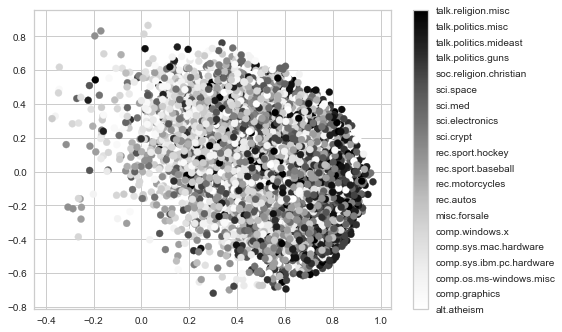

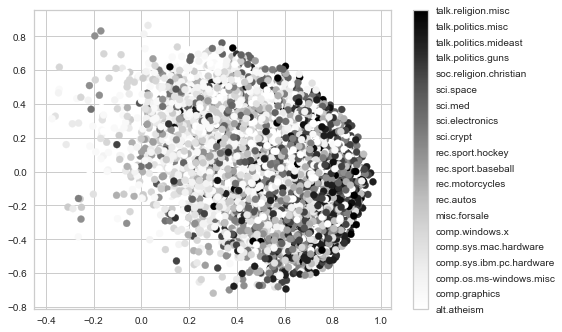

In [72]:
SVD=svd.fit_transform(vector_test)
plt.figure()
plt.scatter(SVD[:,0],SVD[:,1],c=twenty_test.target)
formatter = plt.FuncFormatter(lambda i, args : twenty_test.target_names[int(i)])
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)
plt.figure()
plt.scatter(SVD[:,0],SVD[:,1],c=predicted)
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],format=formatter)

### Transformation Word2Vec

L'objectif de Word2Vec est de générer des représentations vectorielles de mots qui portent des significations sémantiques pour d'autres tâches de la PNL.
Chaque vecteur de mot a généralement plusieurs centaines de dimensions et chaque mot unique du corpus se voit attribuer un vecteur dans l'espace.

La transformation de mots en vecteurs est également connue sous le nom de Word Embedding. La raison de cette transformation est que l'algorithme d'apprentissage machine peut effectuer des opérations d'algèbre linéaire sur des nombres (dans des vecteurs) au lieu de mots.

Pour implémenter Word2Vec, il y a deux choix :
- Continuous Bag-Of-Words (CBOW) 
- Continuous Skip-gram (SG). 

CBOW tente de deviner la sortie (mot cible) à partir de ses mots voisins (mots de contexte) tandis que SG devine les mots de contexte à partir d'un mot cible. 
En effet, Word2Vec est basé sur une hypothèse de distribution où le contexte de chaque mot se trouve dans ses mots voisins. Par conséquent, en examinant les mots voisins, nous pouvons tenter de prédire le mot cible.

Voici la différence entre Skip-gram et CBOW :
- Skip-gram : fonctionne bien avec une petite quantité de données d'entraînement, représente bien même des mots ou des phrases rares
- CBOW : plusieurs fois plus rapide à former que le skip-gram, un peu plus précis pour les mots fréquents

Pour aller plus loin, puisque Skip-gram apprend à prédire les mots de contexte à partir d'un mot donné, dans le cas où deux mots (l'un apparaissant peu fréquemment et l'autre plus fréquemment) sont placés côte à côte, les deux auront le même traitement lorsqu'il s'agira de minimiser la perte puisque chaque mot sera traité à la fois comme le mot cible et le mot de contexte. Par comparaison avec le CBOW, le mot peu fréquent ne sera qu'une partie d'une collection de mots de contexte utilisés pour prédire le mot cible. Par conséquent, le modèle attribuera au mot peu fréquent une faible probabilité.


In [73]:
newsgroups_train = fetch_20newsgroups(subset='train')
sentences_train = [doc.strip().split() for doc in newsgroups_train.data]
newsgroups_test = fetch_20newsgroups(subset='test')
sentences_test = [doc.strip().split() for doc in newsgroups_test.data]                              
# example output of the data
print('raw data:\n\n', newsgroups_train.data[0])
print('example input:\n', sentences_train[0])

raw data:

 From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





example input:
 ['From:', 'lerxst@wam.umd.edu', "(where's", 'my', 'thing)', 'Subject:', 'WHAT', 'car', 'is', 'this!?', 'Nntp-Posting-Host:', 'rac3.wam.umd.edu', 'Organization:', 'University', 'of', 'Maryland,', 'College', 'Park', 'Lines:', '15', 'I', 'was', 'wonderi

In [76]:
workers = cpu_count()
word2vec_train = Word2Vec(sentences_train, workers=workers)
word2vec_test = Word2Vec(sentences_test, workers=workers)
word_vectors_train = pd.DataFrame(word2vec_train.wv.vectors, index=word2vec_train.wv.index2word)
word_vectors_test = pd.DataFrame(word2vec_test.wv.vectors, index=word2vec_test.wv.index2word)
print('word vector dimension: ', word_vectors_train.shape)
word_vectors_train.head()

INFO - 20:06:26: collecting all words and their counts
INFO - 20:06:26: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 20:06:27: PROGRESS: at sentence #10000, processed 2897495 words, keeping 258364 word types
INFO - 20:06:28: collected 280308 word types from a corpus of 3252437 raw words and 11314 sentences
INFO - 20:06:28: Loading a fresh vocabulary
INFO - 20:06:28: effective_min_count=5 retains 44593 unique words (15% of original 280308, drops 235715)
INFO - 20:06:28: effective_min_count=5 leaves 2901696 word corpus (89% of original 3252437, drops 350741)
INFO - 20:06:28: deleting the raw counts dictionary of 280308 items
INFO - 20:06:28: sample=0.001 downsamples 45 most-common words
INFO - 20:06:28: downsampling leaves estimated 2380895 word corpus (82.1% of prior 2901696)
INFO - 20:06:28: estimated required memory for 44593 words and 100 dimensions: 57970900 bytes
INFO - 20:06:28: resetting layer weights
INFO - 20:06:54: training model with 4 workers on 4

INFO - 20:07:58: EPOCH 2 - PROGRESS: at 18.49% examples, 277171 words/s, in_qsize 7, out_qsize 0
INFO - 20:07:59: EPOCH 2 - PROGRESS: at 40.10% examples, 292938 words/s, in_qsize 7, out_qsize 0
INFO - 20:08:00: EPOCH 2 - PROGRESS: at 66.95% examples, 325105 words/s, in_qsize 7, out_qsize 0
INFO - 20:08:01: worker thread finished; awaiting finish of 3 more threads
INFO - 20:08:01: worker thread finished; awaiting finish of 2 more threads
INFO - 20:08:01: worker thread finished; awaiting finish of 1 more threads
INFO - 20:08:01: worker thread finished; awaiting finish of 0 more threads
INFO - 20:08:01: EPOCH - 2 : training on 2093344 raw words (1498721 effective words) took 4.0s, 374005 effective words/s
INFO - 20:08:02: EPOCH 3 - PROGRESS: at 30.02% examples, 446137 words/s, in_qsize 7, out_qsize 0
INFO - 20:08:03: EPOCH 3 - PROGRESS: at 73.73% examples, 537045 words/s, in_qsize 7, out_qsize 3
INFO - 20:08:04: worker thread finished; awaiting finish of 3 more threads
INFO - 20:08:04: wo

word vector dimension:  (44593, 100)


0         1         2         3         4         5         6   \
the -0.153624 -1.508518  0.436248  0.544838 -1.162595 -1.762492  2.367689   
to  -0.947822 -3.703211 -0.573583 -0.132256  2.544882 -1.197369  3.434997   
of   0.450751 -1.234197 -0.988129  0.851267  1.583212 -1.307349  1.378284   
a   -1.369809 -1.340294 -0.926048 -2.166845  0.647957  1.517479  1.837298   
and  0.262637 -1.184476 -1.463302  0.738313  0.278831 -0.904763  1.901934   

           7         8         9   ...        90        91        92  \
the -0.369277 -0.319700  1.257611  ... -0.038588 -2.125179  0.477558   
to  -2.174136 -1.100715  0.169633  ... -1.556239 -1.612253  1.466233   
of  -1.054032  1.723444  2.422148  ... -0.431108 -0.090671 -0.948663   
a   -2.482755 -0.023064 -1.509334  ...  0.732936  0.745486  0.581166   
and -1.938331 -1.699450 -0.068077  ... -0.357731 -1.887419  1.106074   

           93        94        95        96        97        98        99  
the -2.408880  0.006879  1.011510 -0.265721  0.149120 -2.079807 -0.943555  
to   0.812632  0.327728  2.334932 -0.094515 -0.546661  0.819487 -3.258933  
of  -1.489333  2.154580  1.819976 -1.629950 -0.484618 -0.019486  0.608311  
a   -2.345662  2.611383  1.083358  1.725485  1.669281 -1.710898 -4.070353  
and  1.382944  0.698799  0.420435 -0.623441  1.541028 -1.130515 -1.601044  

[5 rows x 100 columns]

In [77]:
word_vectors_train

0         1         2         3         4         5         6   \
the   -0.153624 -1.508518  0.436248  0.544838 -1.162595 -1.762492  2.367689   
to    -0.947822 -3.703211 -0.573583 -0.132256  2.544882 -1.197369  3.434997   
of     0.450751 -1.234197 -0.988129  0.851267  1.583212 -1.307349  1.378284   
a     -1.369809 -1.340294 -0.926048 -2.166845  0.647957  1.517479  1.837298   
and    0.262637 -1.184476 -1.463302  0.738313  0.278831 -0.904763  1.901934   
...         ...       ...       ...       ...       ...       ...       ...   
C/D    0.030197 -0.042824  0.107730  0.050906 -0.028979 -0.174411  0.002625   
open:  0.074614 -0.122709  0.073051  0.016942 -0.047156 -0.074252  0.108342   
J19    0.006316 -0.060564  0.066406  0.013894 -0.010140 -0.038298  0.032075   
|oo|   0.094932 -0.135862 -0.009746  0.075222 -0.015033 -0.012752  0.003261   
DASP   0.000080 -0.081472  0.026431  0.007997 -0.035169 -0.005398  0.031090   

             7         8         9   ...        90        91        92  \
the   -0.369277 -0.319700  1.257611  ... -0.038588 -2.125179  0.477558   
to    -2.174136 -1.100715  0.169633  ... -1.556239 -1.612253  1.466233   
of    -1.054032  1.723444  2.422148  ... -0.431108 -0.090671 -0.948663   
a     -2.482755 -0.023064 -1.509334  ...  0.732936  0.745486  0.581166   
and   -1.938331 -1.699450 -0.068077  ... -0.357731 -1.887419  1.106074   
...         ...       ...       ...  ...       ...       ...       ...   
C/D    0.035314  0.000023 -0.064166  ... -0.045290 -0.062766 -0.035801   
open: -0.012978 -0.007289 -0.040170  ... -0.078884 -0.044506 -0.071001   
J19   -0.022122  0.008276 -0.040475  ...  0.009681 -0.060308 -0.050851   
|oo|  -0.017166  0.005519  0.024623  ... -0.037250 -0.088705  0.018957   
DASP  -0.023213 -0.036174 -0.024322  ...  0.001430 -0.015443  0.006073   

             93        94        95        96        97        98        99  
the   -2.408880  0.006879  1.011510 -0.265721  0.149120 -2.079807 -0.943555  
to     0.812632  0.327728  2.334932 -0.094515 -0.546661  0.819487 -3.258933  
of    -1.489333  2.154580  1.819976 -1.629950 -0.484618 -0.019486  0.608311  
a     -2.345662  2.611383  1.083358  1.725485  1.669281 -1.710898 -4.070353  
and    1.382944  0.698799  0.420435 -0.623441  1.541028 -1.130515 -1.601044  
...         ...       ...       ...       ...       ...       ...       ...  
C/D    0.065132 -0.181130 -0.106159  0.048681  0.049900  0.104574 -0.076755  
open:  0.106397 -0.127843 -0.054110  0.068360  0.006825  0.083752 -0.099001  
J19    0.057765 -0.102107 -0.024806  0.022826  0.013806  0.091492 -0.091624  
|oo|   0.046598 -0.038121 -0.013804 -0.028703 -0.047618  0.092977 -0.006971  
DASP   0.012441 -0.027094 -0.055186  0.053242 -0.005200  0.024919 -0.035362  

[44593 rows x 100 columns]

In [78]:
word_vectors_test

0         1         2         3         4         5   \
the          -0.611692 -2.166789  0.826045  0.589827  1.076248 -0.671085   
to           -0.961606 -1.919912 -0.215887  1.185065  2.653311  1.101886   
of           -0.492124  0.366378  0.454779  0.586194  3.599581 -1.052925   
a            -2.462138 -0.153307  0.028189 -0.095036 -0.788143  0.316850   
and          -0.073506 -0.700379  0.161181  0.522904 -0.237956 -1.660027   
...                ...       ...       ...       ...       ...       ...   
New!          0.073434 -0.031323  0.094825 -0.048550 -0.016920 -0.100248   
[TC]          0.012832 -0.048616  0.119748 -0.012275 -0.001740 -0.112793   
Cosar         0.006407 -0.001202  0.046134  0.017520 -0.031620 -0.037554   
dorsai        0.005157 -0.043510  0.024113  0.022450 -0.015980 -0.079737   
Meteorology,  0.038288  0.003694  0.082741 -0.030050  0.052679 -0.083123   

                    6         7         8         9   ...        90        91  \
the           1.211189  0.405819 -0.287960 -0.002389  ... -0.007205 -1.538467   
to            1.487745 -1.905035  0.031038 -0.393691  ... -2.036400 -0.789393   
of            1.150927 -2.430027  2.126963  0.847835  ... -0.720628 -0.888917   
a             1.083837 -0.572418 -0.165373 -2.038795  ...  0.811799 -0.165098   
and           1.228150 -0.790968 -1.712394  0.487150  ... -1.182719 -1.280444   
...                ...       ...       ...       ...  ...       ...       ...   
New!          0.048532 -0.037546 -0.052145 -0.054318  ... -0.082773  0.068718   
[TC]          0.044560 -0.005200 -0.047656 -0.043756  ... -0.057053  0.106470   
Cosar         0.031701  0.001056 -0.019588  0.004397  ... -0.005308  0.027172   
dorsai        0.035514  0.020091 -0.011731 -0.018540  ... -0.035591  0.013097   
Meteorology, -0.009447 -0.011955  0.009369 -0.049295  ... -0.032408  0.035942   

                    92        93        94        95        96        97  \
the           0.715761 -0.476126 -0.005908  0.701352  0.987843 -0.262687   
to            2.516708  1.436454 -0.733974  2.040605  0.360407  0.040422   
of            0.576281 -1.337932 -0.035420  2.088287  0.988731  1.620506   
a             0.794987 -0.628225  1.107833  0.178197  0.927741  1.218606   
and           1.538766  1.141290 -0.281219  0.652052  0.220015  0.815124   
...                ...       ...       ...       ...       ...       ...   
New!         -0.062768 -0.003754 -0.154827 -0.028313  0.085565 -0.004387   
[TC]         -0.065485  0.010165 -0.133414 -0.001163  0.045816 -0.021796   
Cosar        -0.032333  0.019585 -0.018464 -0.002273  0.048192  0.008688   
dorsai       -0.000072  0.010048 -0.051818  0.013636  0.010532  0.016613   
Meteorology,  0.018857  0.045105 -0.111731 -0.009137  0.030833 -0.023222   

                    98        99  
the          -2.321090 -1.059390  
to            0.524126 -2.857977  
of            0.391131  1.387797  
a             0.468470 -3.836465  
and          -0.856672 -1.387234  
...                ...       ...  
New!          0.140158 -0.007786  
[TC]          0.067241  0.017996  
Cosar         0.024332 -0.063935  
dorsai        0.025232 -0.001395  
Meteorology,  0.026414  0.035070  

[32584 rows x 100 columns]

In [79]:
def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]

    close_words = model.similar_by_word(word)

    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

INFO - 20:13:45: precomputing L2-norms of word weight vectors


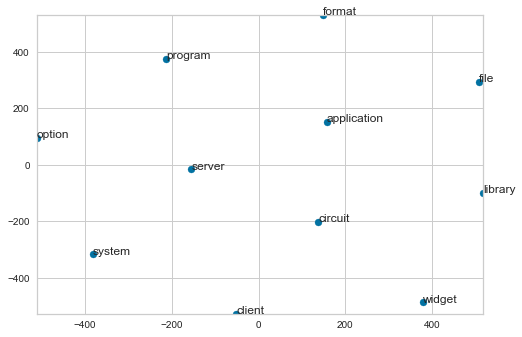

In [80]:
word2vec_train.wv.most_similar(positive=['computer'], topn=5)
display_closestwords_tsnescatterplot(word2vec_train, 'application',100)

Ci dessus, les mots les plus proches du mot "application". On observe que la transformation Word2Vec marche bien. 
En effet, nos connaissances confirme le fait que par exemple, "program", "system", "device", et "widget" font partie de la même catégorie que "application".

Les modèles que nous avons utilisés jusqu'ici prennent en argument des matrices scipy.sparse. Après transformation des données texteuelles avec TF-IDF par exemple, le jeu de données est une matrice scipy.sparse ce qui le rend utilisable facilement. 
Ce n'est pas le cas avec la transformation Word2Vec donc nous n'allons pas appliquer les modèles vus précedemment sur ce nouveau jeu de données. (Bien que dans l'absolu, c'est faisable. Avec d'autres librairies par exmple)

## Transformation doc2vec

Le but de doc2vec est de créer une représentation numérique d'un document, quelle que soit sa longueur. Mais contrairement aux mots, les documents ne viennent pas dans des structures logiques telles que les mots, donc une autre méthode doit être trouvée que celle utilisé par word2vec.
Le concept utilisé est simple, mais intelligent: on utilise le modèle word2vec et on ajoute un autre vecteur (Paragraph ID).

Ainsi, lors de la formation des vecteurs de mots W, le vecteur de document D est également formé et à la fin de la formation il contient une représentation numérique du document.

Le modèle ci-dessous est appelé version à mémoire distribuée du vecteur de paragraphe (PV-DM). Il agit comme une mémoire qui se souvient de ce qui manque dans le contexte actuel - ou comme sujet du paragraphe. Alors que les vecteurs de mots représentent le concept d'un mot, le vecteur de document a l'intention de représenter le concept d'un document.

### 1) Prétraitement des données

Un seul document, composé de «mots» (une liste de tokens de chaîne unicode)
et `tags` (une liste de tokens). Les balises peuvent être une ou plusieurs chaînes Unicode de tokens, mais la pratique typique (qui sera également la plus économe en mémoire) est
que la liste des balises inclue un identifiant entier unique comme seule balise.

In [81]:
twenty_train_tag = []
twenty_test_tag = []

size_train = len(twenty_train.data)
size_test = len(twenty_test.data)

for i in range (0, size_train):
    twenty_train_tag.append(TaggedDocument(words=gensim.utils.simple_preprocess(twenty_train.data[i]), tags=[twenty_train.target_names[twenty_train.target[i]]]))

for i in range (0, size_test):
    twenty_test_tag.append(TaggedDocument(words=gensim.utils.simple_preprocess(twenty_test.data[i]), tags=[twenty_test.target_names[twenty_test.target[i]]]))

### 2) Modèle doc2vec

In [82]:
doc2vec_model = Doc2Vec(vector_size=40)
doc2vec_model.build_vocab([x for x in twenty_train_tag])

INFO - 20:16:16: collecting all words and their counts
INFO - 20:16:16: PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
INFO - 20:16:17: PROGRESS: at example #10000, processed 2865361 words (2998192/s), 84370 word types, 20 tags
INFO - 20:16:17: collected 90299 word types and 20 unique tags from a corpus of 11314 examples and 3211964 words
INFO - 20:16:17: Loading a fresh vocabulary
INFO - 20:16:17: effective_min_count=5 retains 28492 unique words (31% of original 90299, drops 61807)
INFO - 20:16:17: effective_min_count=5 leaves 3108775 word corpus (96% of original 3211964, drops 103189)
INFO - 20:16:18: deleting the raw counts dictionary of 90299 items
INFO - 20:16:18: sample=0.001 downsamples 46 most-common words
INFO - 20:16:18: downsampling leaves estimated 2520104 word corpus (81.1% of prior 3108775)
INFO - 20:16:18: estimated required memory for 28492 words and 40 dimensions: 23370640 bytes
INFO - 20:16:18: resetting layer weights


In [83]:
size_train_tag = len(twenty_train_tag)
for epoch in range(30):
    doc2vec_model.train(utils.shuffle([x for x in twenty_train_tag]), total_examples = size_train_tag, epochs=1)
    doc2vec_model.alpha -= 0.002
    doc2vec_model.min_alpha = doc2vec_model.alpha

INFO - 20:16:30: training model with 3 workers on 28492 vocabulary and 40 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
INFO - 20:16:32: EPOCH 1 - PROGRESS: at 10.58% examples, 245216 words/s, in_qsize 5, out_qsize 0
INFO - 20:16:33: EPOCH 1 - PROGRESS: at 18.74% examples, 228872 words/s, in_qsize 5, out_qsize 0
INFO - 20:16:34: EPOCH 1 - PROGRESS: at 27.44% examples, 221497 words/s, in_qsize 6, out_qsize 0
INFO - 20:16:35: EPOCH 1 - PROGRESS: at 37.46% examples, 225235 words/s, in_qsize 5, out_qsize 0
INFO - 20:16:36: EPOCH 1 - PROGRESS: at 50.15% examples, 238708 words/s, in_qsize 5, out_qsize 0
INFO - 20:16:37: EPOCH 1 - PROGRESS: at 62.24% examples, 251450 words/s, in_qsize 5, out_qsize 0
INFO - 20:16:38: EPOCH 1 - PROGRESS: at 77.67% examples, 270561 words/s, in_qsize 5, out_qsize 0
INFO - 20:16:39: EPOCH 1 - PROGRESS: at 96.18% examples, 295683 words/s, in_qsize 5, out_qsize 0
INFO - 20:16:39: worker thread finished; awaiting finish of 2 more threads
INFO - 20:16:39:

INFO - 20:17:15: EPOCH 1 - PROGRESS: at 13.45% examples, 316675 words/s, in_qsize 5, out_qsize 0
INFO - 20:17:17: EPOCH 1 - PROGRESS: at 26.37% examples, 321063 words/s, in_qsize 6, out_qsize 0
INFO - 20:17:18: EPOCH 1 - PROGRESS: at 36.72% examples, 302476 words/s, in_qsize 5, out_qsize 0
INFO - 20:17:19: EPOCH 1 - PROGRESS: at 49.68% examples, 305691 words/s, in_qsize 5, out_qsize 0
INFO - 20:17:20: EPOCH 1 - PROGRESS: at 63.29% examples, 311799 words/s, in_qsize 5, out_qsize 0
INFO - 20:17:21: EPOCH 1 - PROGRESS: at 76.62% examples, 317033 words/s, in_qsize 5, out_qsize 0
INFO - 20:17:22: EPOCH 1 - PROGRESS: at 88.19% examples, 315452 words/s, in_qsize 5, out_qsize 0
INFO - 20:17:23: EPOCH 1 - PROGRESS: at 97.71% examples, 306538 words/s, in_qsize 5, out_qsize 0
INFO - 20:17:23: worker thread finished; awaiting finish of 2 more threads
INFO - 20:17:23: worker thread finished; awaiting finish of 1 more threads
INFO - 20:17:23: worker thread finished; awaiting finish of 0 more threads

INFO - 20:18:01: EPOCH 1 - PROGRESS: at 89.80% examples, 567119 words/s, in_qsize 5, out_qsize 0
INFO - 20:18:01: worker thread finished; awaiting finish of 2 more threads
INFO - 20:18:01: worker thread finished; awaiting finish of 1 more threads
INFO - 20:18:01: worker thread finished; awaiting finish of 0 more threads
INFO - 20:18:01: EPOCH - 1 : training on 3211964 raw words (2531140 effective words) took 4.8s, 528355 effective words/s
INFO - 20:18:01: training on a 3211964 raw words (2531140 effective words) took 4.8s, 527699 effective words/s
INFO - 20:18:01: training model with 3 workers on 28492 vocabulary and 40 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
INFO - 20:18:02: EPOCH 1 - PROGRESS: at 12.77% examples, 327910 words/s, in_qsize 5, out_qsize 0
INFO - 20:18:03: EPOCH 1 - PROGRESS: at 26.57% examples, 323677 words/s, in_qsize 4, out_qsize 1
INFO - 20:18:04: EPOCH 1 - PROGRESS: at 40.19% examples, 334548 words/s, in_qsize 6, out_qsize 0
INFO - 20:18:05: EPOCH

INFO - 20:18:41: EPOCH 1 - PROGRESS: at 41.60% examples, 518957 words/s, in_qsize 5, out_qsize 0
INFO - 20:18:42: EPOCH 1 - PROGRESS: at 62.18% examples, 523812 words/s, in_qsize 5, out_qsize 0
INFO - 20:18:43: EPOCH 1 - PROGRESS: at 86.10% examples, 540887 words/s, in_qsize 5, out_qsize 0
INFO - 20:18:44: worker thread finished; awaiting finish of 2 more threads
INFO - 20:18:44: worker thread finished; awaiting finish of 1 more threads
INFO - 20:18:44: worker thread finished; awaiting finish of 0 more threads
INFO - 20:18:44: EPOCH - 1 : training on 3211964 raw words (2531539 effective words) took 4.7s, 538592 effective words/s
INFO - 20:18:44: training on a 3211964 raw words (2531539 effective words) took 4.7s, 538075 effective words/s
INFO - 20:18:44: training model with 3 workers on 28492 vocabulary and 40 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
INFO - 20:18:45: EPOCH 1 - PROGRESS: at 11.99% examples, 289380 words/s, in_qsize 5, out_qsize 0
INFO - 20:18:46: EPOCH

Faire correspondre chaque tokens du document avec la cible du document

In [84]:
def vec_splitting(model, docs):
    doc2vec_vectors = [model.infer_vector(doc.words) for doc in docs]
    targets = [doc.tags[0] for doc in docs]
    return doc2vec_vectors, targets

In [85]:
X_train, y_train = vec_splitting(doc2vec_model, twenty_train_tag)
X_test, y_test = vec_splitting(doc2vec_model, twenty_test_tag)

### Evaluation de nos classifieurs avec doc2vec

In [86]:
def evaluate_model_doc2vec(classifieur, xtrain, ytrain, xtest, ytest):
    score = []
    for clf in classifieur:
        clf.fit(xtrain, ytrain)
        predicted = clf.predict(xtest)
        acc = accuracy_score(ytest, predicted)
        score.append(acc)
        print('Modèle : %s\n' % clf)
        print('Testing accuracy of %s' % acc)
        print('Testing F1 score: {}'.format(f1_score(ytest, predicted, average='weighted')))   
        print('---------------------------------------------------------------------------\n')
    return score

In [87]:
models = [SGDClassifier(), KNeighborsClassifier(), LogisticRegression(), DecisionTreeClassifier(), LinearSVC()]
score = evaluate_model_doc2vec(models, X_train, y_train , X_test, y_test)

Modèle : SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Testing accuracy of 0.6785714285714286
Testing F1 score: 0.682718141616508
---------------------------------------------------------------------------

Modèle : KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Testing accuracy of 0.4674721189591078
Testing F1 score: 0.479675277300322
---------------------------------------------------------------------------

Modèle : LogisticRegression(C=1.0, class_weight=None, dual=False,

In [88]:
accuracy_doc2vec = [['SGD', score[0]], ['KNN', score[1]], ['Rég.Logistique', score[2]], ['Decision Tree', score[3]], ['SVC', score[4]]]
comp2 = pd.DataFrame(accuracy_doc2vec, columns =['Classifieurs', 'Best Score'])

In [89]:
size = [score[0], score[1], score[2], score[3], score[4]]

import plotly.graph_objects as go
fig = go.Figure(data=[go.Scatter(
    x=comp2["Classifieurs"], y=comp2["Best Score"],
    mode='markers',
    marker=dict(
        size=size,
        sizemode='area',
        sizeref=2.*max(size)/(40.**2),
        sizemin=4
    ))
])
fig.update_layout(
    title="Comparaison des différents modèles d'apprentissage supervisé",
    xaxis_title="Modèle",
    yaxis_title="Accuracy",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

La régression logistique est le meilleure classifieur en utilisant doc2vec.

## 20 newsgroups topics avec LDA

Latent Dirichlet Allocation est un modèle probabiliste génératif pour les collections de données discrètes telles que les corpus de texte. 
C'est également un modèle de recherche de sujet (topics) qui est utilisé pour découvrir et extraire des sujets abstraits à partir d'une collection de documents.

Lorsque LDA est appliqué sur une matrice «document-terme», la matrice sera décomposée en une matrice «sujet-terme» et une matrice «document-sujet». Alors que la matrice «sujet-terme» est stockée en tant que composants_ dans le modèle, la matrice «document-sujet» peut être calculée à partir de la méthode de transformation.

Nous allons ici comparer les sujets et les 5 mots les plus représentés dans ces sujets trouvés avec la LDA.

In [90]:
all_vect = count_vect.fit_transform(twenty_all.data)

lda = LatentDirichletAllocation(n_components=8, random_state=0)
lda.fit(all_vect)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=8, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [91]:
n_top_words = 5
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [92]:
print("\nTopics in LDA model:")
tf_feature_names = count_vect.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words) 


Topics in LDA model:
Topic #0: 00 subject file lines 10
Topic #1: space nasa db henry launch
Topic #2: edu people subject lines writes
Topic #3: god people edu think don
Topic #4: edu subject lines organization com
Topic #5: com edu writes subject article
Topic #6: edu com organization subject lines
Topic #7: ax max g9v b8f a86



### Observation : 

Le modèle LDA trouve 7 topics différents, mais certains mots apparaissent dans plusieurs topics comme c'est le cas de edu dans le topic 2,3,4,5 et 6.

# Jeu de données sur les voitures

Nous nous interressons maintenant à un jeu de donnée sur les voitures. Cet ensemble de données comprend des caractéristiques telles que la marque, le modèle, l'année, le moteur et d'autres propriétés de la voiture. Nous utiliserons ces caractéristiques pour générer les mots incorporés pour chaque modèle de marque, puis nous comparerons les similitudes entre les différents modèles de marque. L'objectif de cette partie est d'utiliser word2Vec de la bibliothèque Genism.

In [93]:
df = pd.read_csv('data.csv')
df.head()

Make       Model  Year             Engine Fuel Type  Engine HP  \
0  BMW  1 Series M  2011  premium unleaded (required)      335.0   
1  BMW    1 Series  2011  premium unleaded (required)      300.0   
2  BMW    1 Series  2011  premium unleaded (required)      300.0   
3  BMW    1 Series  2011  premium unleaded (required)      230.0   
4  BMW    1 Series  2011  premium unleaded (required)      230.0   

   Engine Cylinders Transmission Type     Driven_Wheels  Number of Doors  \
0               6.0            MANUAL  rear wheel drive              2.0   
1               6.0            MANUAL  rear wheel drive              2.0   
2               6.0            MANUAL  rear wheel drive              2.0   
3               6.0            MANUAL  rear wheel drive              2.0   
4               6.0            MANUAL  rear wheel drive              2.0   

                         Market Category Vehicle Size Vehicle Style  \
0  Factory Tuner,Luxury,High-Performance      Compact         Coupe   
1                     Luxury,Performance      Compact   Convertible   
2                Luxury,High-Performance      Compact         Coupe   
3                     Luxury,Performance      Compact         Coupe   
4                                 Luxury      Compact   Convertible   

   highway MPG  city mpg  Popularity   MSRP  
0           26        19        3916  46135  
1           28        19        3916  40650  
2           28        20        3916  36350  
3           28        18        3916  29450  
4           28        18        3916  34500

### Péparation des données 

Genism word2Vec nécessite un format de liste de liste pour la formation où chaque document est contenu dans une liste et chaque liste contient la liste des jetons de ce document. Dans un premier temps, nous devons générer un format de liste de liste pour l'apprentissage de l'intégration des mots du modèle make. Pour être plus précis, chaque modèle de marque est contenu dans une liste et chaque liste contient la liste des caractéristiques de ce modèle de marque. Pour y parvenir, nous devons effectuer les étapes suivantes de prétraitement des données :

- Créer une nouvelle colonne pour Make Model
- Générer un format de liste de liste pour chaque Make Model avec les caractéristiques suivantes : Type de carburant du moteur, type de transmission, roues motrices, catégorie de marché, taille et style du véhicule.




In [94]:
df['Maker_Model']= df['Make']+ " " + df['Model']

In [95]:

df1 = df[['Engine Fuel Type','Transmission Type','Driven_Wheels','Market Category','Vehicle Size', 'Vehicle Style', 'Maker_Model']]

df2 = df1.apply(lambda x: ','.join(x.astype(str)), axis=1) 

df_clean = pd.DataFrame({'clean': df2}) 

sent = [row.split(',') for row in df_clean['clean']]

sent[:2]

[['premium unleaded (required)',
  'MANUAL',
  'rear wheel drive',
  'Factory Tuner',
  'Luxury',
  'High-Performance',
  'Compact',
  'Coupe',
  'BMW 1 Series M'],
 ['premium unleaded (required)',
  'MANUAL',
  'rear wheel drive',
  'Luxury',
  'Performance',
  'Compact',
  'Convertible',
  'BMW 1 Series']]

### Genism word2Vec

In [96]:
model = Word2Vec(sent, min_count=1,size= 50,workers=3, window =3, sg = 1)

WARNING - 20:23:01: consider setting layer size to a multiple of 4 for greater performance
INFO - 20:23:01: collecting all words and their counts
INFO - 20:23:01: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 20:23:01: PROGRESS: at sentence #10000, processed 74060 words, keeping 841 word types
INFO - 20:23:01: collected 977 word types from a corpus of 88129 raw words and 11914 sentences
INFO - 20:23:01: Loading a fresh vocabulary
INFO - 20:23:01: effective_min_count=1 retains 977 unique words (100% of original 977, drops 0)
INFO - 20:23:02: effective_min_count=1 leaves 88129 word corpus (100% of original 88129, drops 0)
INFO - 20:23:02: deleting the raw counts dictionary of 977 items
INFO - 20:23:02: sample=0.001 downsamples 35 most-common words
INFO - 20:23:02: downsampling leaves estimated 29996 word corpus (34.0% of prior 88129)
INFO - 20:23:02: estimated required memory for 977 words and 50 dimensions: 879300 bytes
INFO - 20:23:02: resetting layer weights

In [97]:
model['Toyota Camry']

array([-0.06292582, -0.07563344, -0.01159056, -0.13445134,  0.08688412,
        0.13274862,  0.01015259,  0.19721541, -0.06087537,  0.18116504,
        0.15893172,  0.16702543, -0.2013605 ,  0.21312855, -0.12833478,
       -0.15601984, -0.17820866,  0.04719052, -0.18438214,  0.2015857 ,
       -0.08539291,  0.06697357, -0.21008454,  0.15631582,  0.17556123,
       -0.17538196,  0.08186849,  0.03653606,  0.0253184 , -0.01312738,
        0.0192891 ,  0.06518205,  0.07548136, -0.06564497, -0.11310015,
        0.19358408,  0.11680334, -0.12728304, -0.08255146,  0.02950816,
        0.09223454, -0.09146263, -0.03605332,  0.03855836,  0.12609747,
        0.12742142, -0.0492793 ,  0.21331891, -0.11001319,  0.12303941],
      dtype=float32)

## Comparaison des similitudes

In [98]:
model.similarity('Porsche 718 Cayman', 'Nissan Van')

0.90352654

In [99]:
model.similarity('Porsche 718 Cayman', 'Mercedes-Benz SLK-Class')

0.94142103

In [100]:
model.most_similar('Mercedes-Benz SLK-Class')[:5]

INFO - 20:23:02: precomputing L2-norms of word weight vectors


[('Cadillac CTS Coupe', 0.9941972494125366),
 ('Infiniti Q60 Convertible', 0.9940927028656006),
 ('Rolls-Royce Ghost', 0.9938031435012817),
 ('Bentley Continental Supersports', 0.9933162331581116),
 ('Maybach 62', 0.9924008250236511)]

In [101]:
model.most_similar('Toyota Camry')[:5]

[('Ford Fusion', 0.9937803745269775),
 ('Nissan Altima', 0.9934348464012146),
 ('Kia Optima Hybrid', 0.9933849573135376),
 ('Mazda Millenia', 0.992642879486084),
 ('Toyota Avalon Hybrid', 0.9902927875518799)]

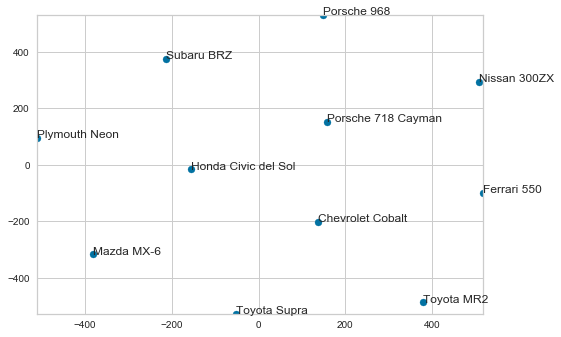

In [102]:
display_closestwords_tsnescatterplot(model, 'Porsche 718 Cayman', 50)

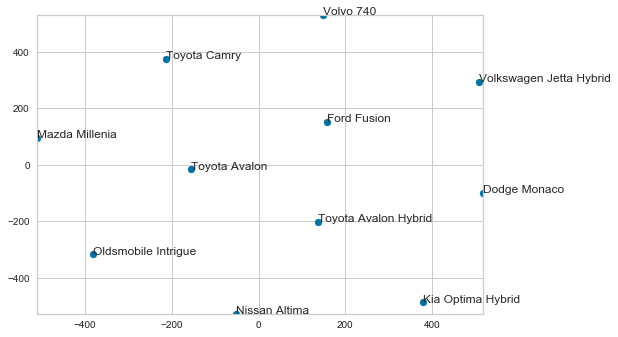

In [103]:
display_closestwords_tsnescatterplot(model, 'Ford Fusion', 50)

Encore une fois, la transformation des données textuelles avec Word2Vec permet de visualiser graphiquement la similarté entre mots.

# Conclusion

Durant ce projet, nous nous sommes principalement concentré sur les données $20 newsgroups$.
Ces données étant textuelles, nous avons procédé à différentes transformations en vecteurs (principalement TF-IDF).
Une fois ces données textuelles "vectorisées", nous avons appliqué plusieurs modèles d'apprentissage dessus afin de comparer lequel classait le mieux les documents. 
Pour chaque modèle, nous avons fait un $Grid Search$ pour trouver les paramètres qui amenaient au meilleur score.

Afin de visualiser graphiquement les résulats de chaque modèle, nous avons utilisé des techniques de réduction de dimensions (SVD et NMF).

Pour les modèles non supervisés (k Means), nous avons tester plusieurs mesures d'efficacité et les avons comparé pour trouver les bons paramètres (nombre de clusters).

Notre conclusion est que pour les données textuelles, le modèle Linear Support Vector Classification (SVC) obtient le meilleur taux de classification et les arbres de décision le moins bon.

Pour élargir cette vérité, il faudrait bien entendu refaire toutes ces comparaisons sur un plus grand nombre de jeux de données. Afin de "comparer ces comparaisons".